In [1]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from utils import get_img_obj_points
from utils import cal_undistort
from utils import *

import numpy as np
import glob
# Read in an image

fnames = glob.glob("camera_cal/*.jpg")

img_points_list = []
obj_points_list = []
for fname in fnames :
    img = cv2.imread(fname)
    nx = 9  # the number of inside corners in x
    ny = 6  # the number of inside corners in y
    img_points, obj_points = get_img_obj_points(img, nx, ny)
    img_points_list+=img_points
    obj_points_list+=obj_points



# Undistort

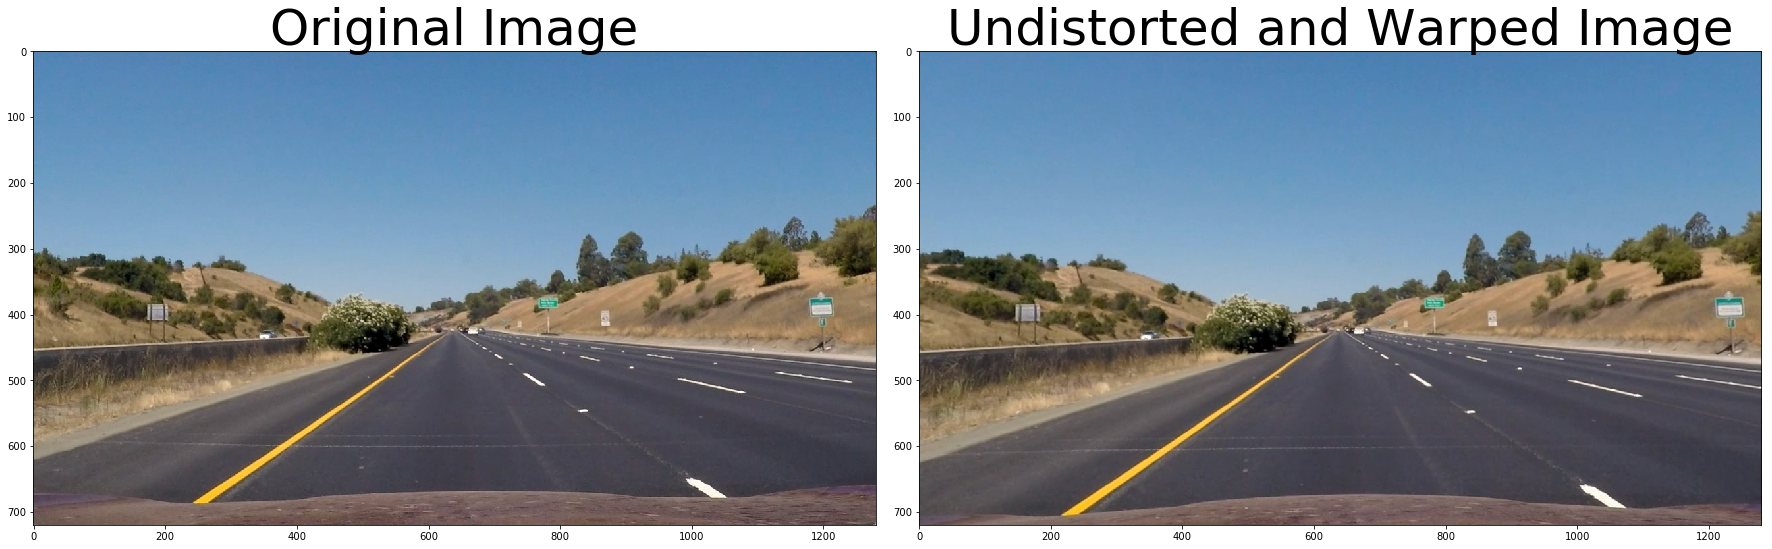

In [2]:
img = mpimg.imread('straight_lines1.jpg')
height, width  = img.shape[0], img.shape[1]
undistorted, dist, mtx = cal_undistort(img, obj_points_list, img_points_list)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Sobel filters

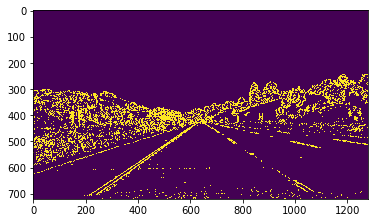

In [3]:
image = undistorted.copy()
combined = np.zeros((height,width), dtype = np.uint8)
combined_condition = sobel_filter(image)
combined[combined_condition] = 1
plt.imshow(combined)
plt.show()

# RGB Filter

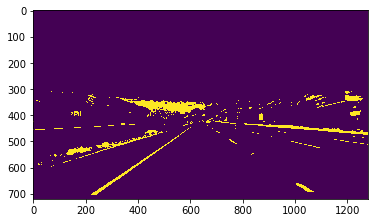

In [4]:
rgb = np.copy(undistorted)
color_combined = np.zeros((height,width), dtype = np.uint8)
r_g_condition = rgb_filter(rgb)
color_combined[r_g_condition] = 1
plt.imshow(color_combined)
plt.show()


# HLS filter

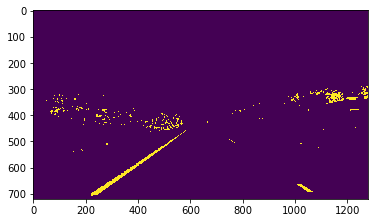

In [5]:
img = np.copy(undistorted)
s_binary = np.zeros((height,width), dtype = np.uint8)
s_binary_condition = hls_filter(img)
s_binary[s_binary_condition] = 1
plt.imshow(s_binary)
plt.show()

# Combined

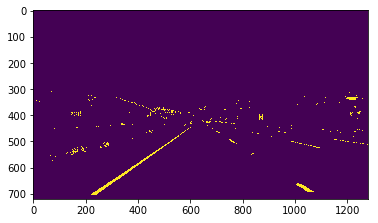

In [6]:
# Combine the two binary thresholds
combined_binary = np.zeros((height,width), dtype = np.uint8)
combined_binary[(r_g_condition ) & (s_binary_condition | combined_condition) ] = 1
plt.imshow(combined_binary)
plt.show()

# Region of intersect

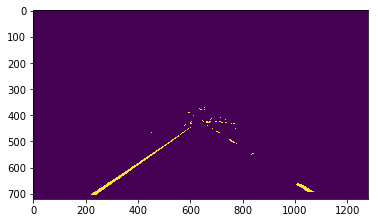

In [7]:

# apply the region of interest mask
mask = np.zeros_like(combined_binary)
region_of_intersect = np.array([[0,height], [width/2, int(0.5*height)], [width, height]], dtype=np.int32)
cv2.fillPoly(mask, [region_of_intersect], 1)
thresholded = cv2.bitwise_and(combined_binary, mask)

plt.imshow(thresholded)
plt.show()

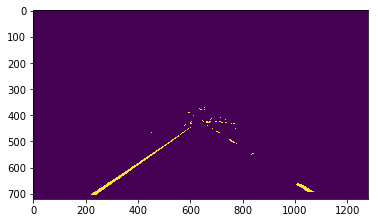

In [8]:
from utils import filter_image
filtered_image = filter_image(undistorted.copy())
plt.imshow(filtered_image)
plt.show()

# Perspective Transform

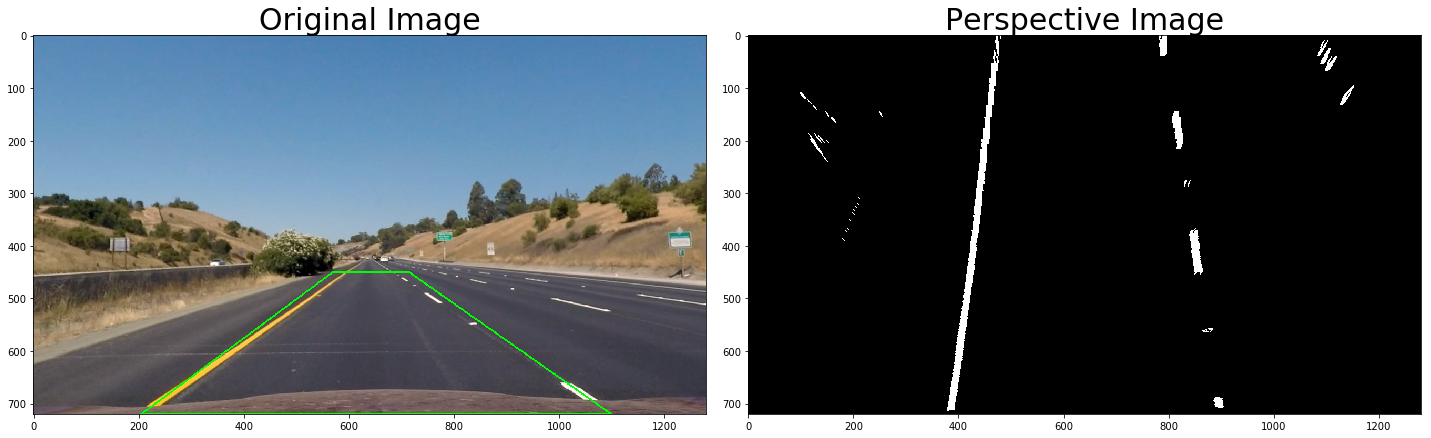

In [9]:
# # Vertices extracted manually for performing a perspective transform
warped, filled = perspective_transform_with_filled_area(img.copy(), filtered_image)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
f.tight_layout()
ax1.imshow(filled)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warped, cmap='gray')
ax2.set_title('Perspective Image', fontsize=30)
plt.show()


#### 

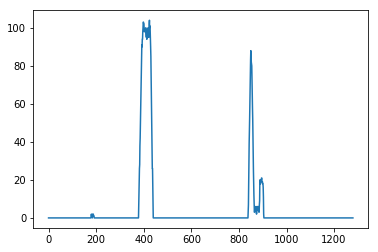

In [10]:
histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()

(720, 0)

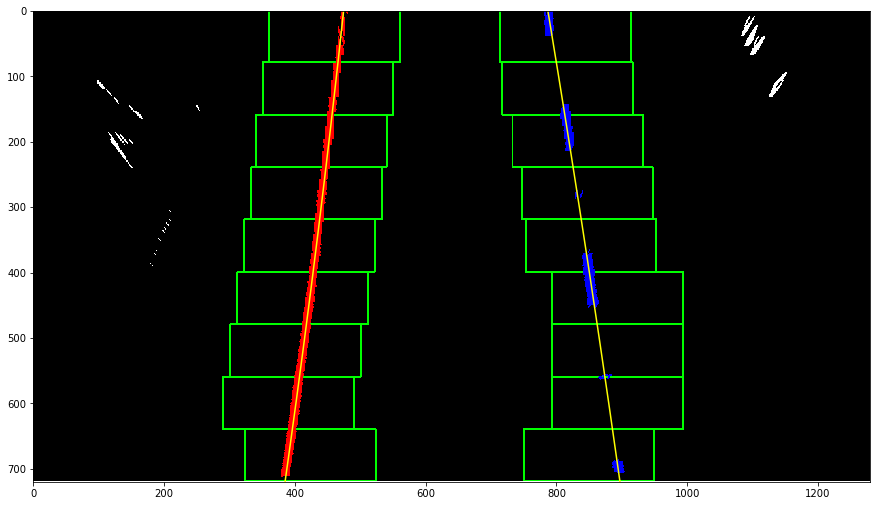

In [11]:
ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = get_lane_rectangles(warped)

# Generate x and y values for plotting

plt.figure(figsize=(15,15))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

(720, 0)

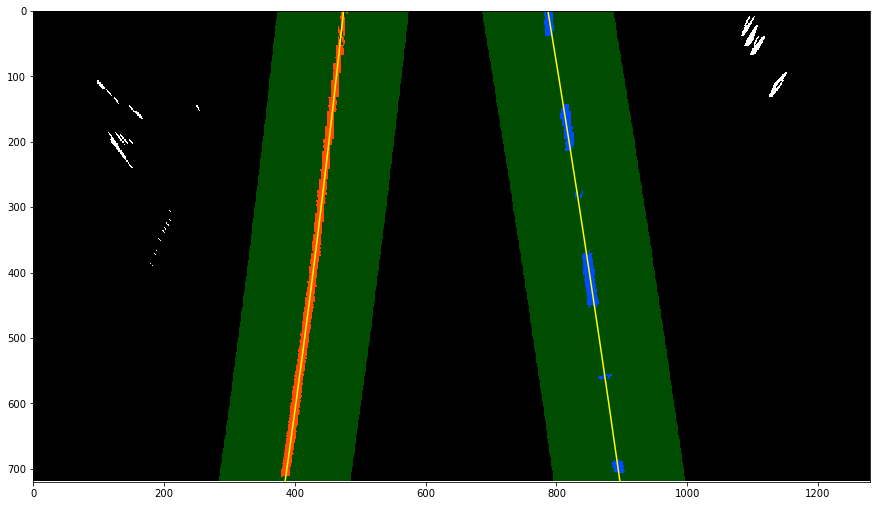

In [12]:
result, ploty, left_fitx, right_fitx, left_fit, right_fit = get_next_frame_lines(warped, left_fit, right_fit)
plt.figure(figsize=(15,15))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [13]:
left_rad_curvature = get_curvature_radius(left_fit, ploty)
right_rad_curvature = get_curvature_radius(right_fit, ploty)
avg_rad_curvature = (left_rad_curvature+right_rad_curvature)/2
print('radius : ', avg_rad_curvature)

radius :  8218.483044817858


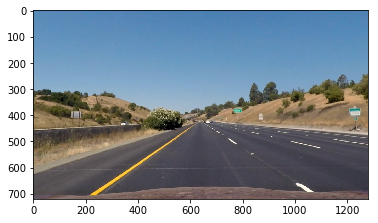

In [14]:
plt.imshow(img)
plt.show()

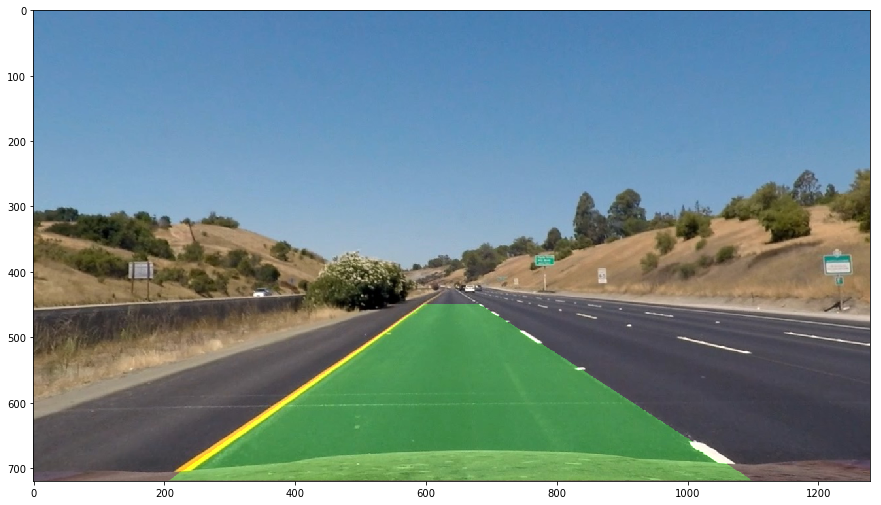

In [15]:
result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)
plt.figure(figsize=(15, 15))
plt.imshow(result)

In [19]:
def pipeline_final(img):
    filtered_image = filter_image(img)
    warped, filled = perspective_transform_with_filled_area(img, filtered_image)
    ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = get_lane_rectangles(warped)
    result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)
    result = add_debug_image(base_image=result, debug_image=filtered_image, position=0)
    result = add_debug_image(base_image=result, debug_image=warped, position=1)
    result = add_debug_image(base_image=result, debug_image=out_img, position=2)

    return result

def pipeline_final_debug(img):
    filtered_image = filter_image(img)
    warped, filled = perspective_transform_with_filled_area(img, filtered_image)
    ploty, left_fitx, right_fitx, left_fit, right_fit, out_img = get_lane_rectangles(warped)
    result = inverse_perspective_transform(img, warped, left_fitx, right_fitx, ploty)
    result = add_debug_image(base_image=result, debug_image=filtered_image, position=0)
    result = add_debug_image(base_image=result, debug_image=warped, position=1)
    result = add_debug_image(base_image=result, debug_image=out_img, position=2)

    return result

0 0
0 426
0 852


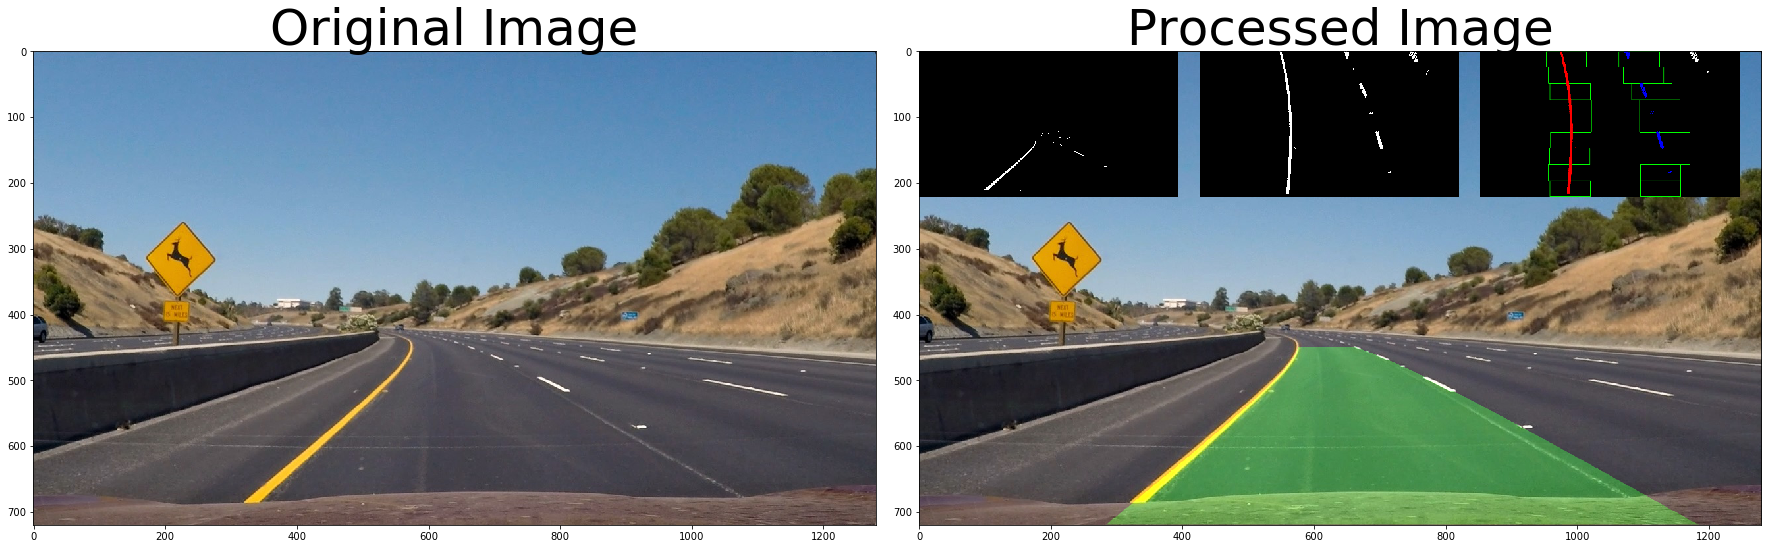

In [17]:
img = mpimg.imread('test_images/test2.jpg')

# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0

# Apply pipeline
processed = pipeline_final(img)

# Plot the 2 images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(processed, cmap='gray')
ax2.set_title('Processed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [18]:
from moviepy.editor import VideoFileClip
# Reinitialize some global variables.
polyfit_left = None
polyfit_right = None
past_good_right_lines = []
past_good_left_lines = []
running_mean_difference_between_lines = 0


output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline_final) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

0 0
0 426
0 852
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

0 0
0 426
0 852


  0%|          | 1/1261 [00:00<03:25,  6.14it/s]

0 0
0 426
0 852


  0%|          | 2/1261 [00:00<03:25,  6.14it/s]

0 0
0 426
0 852


  0%|          | 3/1261 [00:00<03:25,  6.11it/s]

0 0
0 426
0 852


  0%|          | 4/1261 [00:00<03:29,  6.01it/s]

0 0
0 426
0 852


  0%|          | 5/1261 [00:00<03:28,  6.04it/s]

0 0
0 426
0 852


  0%|          | 6/1261 [00:00<03:26,  6.09it/s]

0 0
0 426
0 852


  1%|          | 7/1261 [00:01<03:24,  6.14it/s]

0 0
0 426
0 852


  1%|          | 8/1261 [00:01<03:27,  6.03it/s]

0 0
0 426
0 852


  1%|          | 9/1261 [00:01<03:24,  6.11it/s]

0 0
0 426
0 852


  1%|          | 10/1261 [00:01<03:28,  6.00it/s]

0 0
0 426
0 852


  1%|          | 11/1261 [00:01<03:25,  6.09it/s]

0 0
0 426
0 852


  1%|          | 12/1261 [00:01<03:28,  5.98it/s]

0 0
0 426
0 852


  1%|          | 13/1261 [00:02<03:27,  6.03it/s]

0 0
0 426
0 852


  1%|          | 14/1261 [00:02<03:25,  6.06it/s]

0 0
0 426
0 852


  1%|          | 15/1261 [00:02<03:24,  6.09it/s]

0 0
0 426
0 852


  1%|▏         | 16/1261 [00:02<03:26,  6.04it/s]

0 0
0 426
0 852


  1%|▏         | 17/1261 [00:02<03:23,  6.12it/s]

0 0
0 426
0 852


  1%|▏         | 18/1261 [00:02<03:25,  6.05it/s]

0 0
0 426
0 852


  2%|▏         | 19/1261 [00:03<03:22,  6.13it/s]

0 0
0 426
0 852


  2%|▏         | 20/1261 [00:03<03:23,  6.11it/s]

0 0
0 426
0 852


  2%|▏         | 21/1261 [00:03<03:20,  6.20it/s]

0 0
0 426
0 852


  2%|▏         | 22/1261 [00:03<03:25,  6.02it/s]

0 0
0 426
0 852


  2%|▏         | 23/1261 [00:03<03:22,  6.12it/s]

0 0
0 426
0 852


  2%|▏         | 24/1261 [00:03<03:24,  6.05it/s]

0 0
0 426
0 852


  2%|▏         | 25/1261 [00:04<03:25,  6.02it/s]

0 0
0 426
0 852


  2%|▏         | 26/1261 [00:04<03:22,  6.11it/s]

0 0
0 426
0 852


  2%|▏         | 27/1261 [00:04<03:19,  6.19it/s]

0 0
0 426
0 852


  2%|▏         | 28/1261 [00:04<03:20,  6.14it/s]

0 0
0 426
0 852


  2%|▏         | 29/1261 [00:04<03:22,  6.08it/s]

0 0
0 426
0 852


  2%|▏         | 30/1261 [00:04<03:23,  6.05it/s]

0 0
0 426
0 852


  2%|▏         | 31/1261 [00:05<03:23,  6.04it/s]

0 0
0 426
0 852


  3%|▎         | 32/1261 [00:05<03:29,  5.88it/s]

0 0
0 426
0 852


  3%|▎         | 33/1261 [00:05<03:25,  5.97it/s]

0 0
0 426
0 852


  3%|▎         | 34/1261 [00:05<03:30,  5.84it/s]

0 0
0 426
0 852


  3%|▎         | 35/1261 [00:05<03:29,  5.84it/s]

0 0
0 426
0 852


  3%|▎         | 36/1261 [00:05<03:24,  5.98it/s]

0 0
0 426
0 852


  3%|▎         | 37/1261 [00:06<03:20,  6.10it/s]

0 0
0 426
0 852


  3%|▎         | 38/1261 [00:06<03:17,  6.18it/s]

0 0
0 426
0 852


  3%|▎         | 39/1261 [00:06<03:16,  6.21it/s]

0 0
0 426
0 852


  3%|▎         | 40/1261 [00:06<03:15,  6.25it/s]

0 0
0 426
0 852


  3%|▎         | 41/1261 [00:06<03:14,  6.27it/s]

0 0
0 426
0 852


  3%|▎         | 42/1261 [00:06<03:13,  6.29it/s]

0 0
0 426
0 852


  3%|▎         | 43/1261 [00:07<03:14,  6.28it/s]

0 0
0 426
0 852


  3%|▎         | 44/1261 [00:07<03:16,  6.20it/s]

0 0
0 426
0 852


  4%|▎         | 45/1261 [00:07<03:16,  6.18it/s]

0 0
0 426
0 852


  4%|▎         | 46/1261 [00:07<03:15,  6.20it/s]

0 0
0 426
0 852


  4%|▎         | 47/1261 [00:07<03:16,  6.17it/s]

0 0
0 426
0 852


  4%|▍         | 48/1261 [00:07<03:16,  6.17it/s]

0 0
0 426
0 852


  4%|▍         | 49/1261 [00:08<03:15,  6.19it/s]

0 0
0 426
0 852


  4%|▍         | 50/1261 [00:08<03:18,  6.09it/s]

0 0
0 426
0 852


  4%|▍         | 51/1261 [00:08<03:17,  6.13it/s]

0 0
0 426
0 852


  4%|▍         | 52/1261 [00:08<03:19,  6.06it/s]

0 0
0 426
0 852


  4%|▍         | 53/1261 [00:08<03:18,  6.08it/s]

0 0
0 426
0 852


  4%|▍         | 54/1261 [00:08<03:17,  6.11it/s]

0 0
0 426
0 852


  4%|▍         | 55/1261 [00:09<03:15,  6.16it/s]

0 0
0 426
0 852


  4%|▍         | 56/1261 [00:09<03:15,  6.18it/s]

0 0
0 426
0 852


  5%|▍         | 57/1261 [00:09<03:13,  6.21it/s]

0 0
0 426
0 852


  5%|▍         | 58/1261 [00:09<03:13,  6.22it/s]

0 0
0 426
0 852


  5%|▍         | 59/1261 [00:09<03:12,  6.24it/s]

0 0
0 426
0 852


  5%|▍         | 60/1261 [00:09<03:15,  6.14it/s]

0 0
0 426
0 852


  5%|▍         | 61/1261 [00:09<03:16,  6.09it/s]

0 0
0 426
0 852


  5%|▍         | 62/1261 [00:10<03:21,  5.94it/s]

0 0
0 426
0 852


  5%|▍         | 63/1261 [00:10<03:18,  6.03it/s]

0 0
0 426
0 852


  5%|▌         | 64/1261 [00:10<03:16,  6.11it/s]

0 0
0 426
0 852


  5%|▌         | 65/1261 [00:10<03:16,  6.08it/s]

0 0
0 426
0 852


  5%|▌         | 66/1261 [00:10<03:14,  6.14it/s]

0 0
0 426
0 852


  5%|▌         | 67/1261 [00:10<03:13,  6.17it/s]

0 0
0 426
0 852


  5%|▌         | 68/1261 [00:11<03:11,  6.23it/s]

0 0
0 426
0 852


  5%|▌         | 69/1261 [00:11<03:10,  6.25it/s]

0 0
0 426
0 852


  6%|▌         | 70/1261 [00:11<03:13,  6.17it/s]

0 0
0 426
0 852


  6%|▌         | 71/1261 [00:11<03:16,  6.06it/s]

0 0
0 426
0 852


  6%|▌         | 72/1261 [00:11<03:17,  6.03it/s]

0 0
0 426
0 852


  6%|▌         | 73/1261 [00:11<03:16,  6.06it/s]

0 0
0 426
0 852


  6%|▌         | 74/1261 [00:12<03:16,  6.05it/s]

0 0
0 426
0 852


  6%|▌         | 75/1261 [00:12<03:14,  6.08it/s]

0 0
0 426
0 852


  6%|▌         | 76/1261 [00:12<03:12,  6.14it/s]

0 0
0 426
0 852


  6%|▌         | 77/1261 [00:12<03:14,  6.10it/s]

0 0
0 426
0 852


  6%|▌         | 78/1261 [00:12<03:15,  6.06it/s]

0 0
0 426
0 852


  6%|▋         | 79/1261 [00:12<03:13,  6.12it/s]

0 0
0 426
0 852


  6%|▋         | 80/1261 [00:13<03:13,  6.09it/s]

0 0
0 426
0 852


  6%|▋         | 81/1261 [00:13<03:12,  6.14it/s]

0 0
0 426
0 852


  7%|▋         | 82/1261 [00:13<03:12,  6.14it/s]

0 0
0 426
0 852


  7%|▋         | 83/1261 [00:13<03:12,  6.11it/s]

0 0
0 426
0 852


  7%|▋         | 84/1261 [00:13<03:13,  6.10it/s]

0 0
0 426
0 852


  7%|▋         | 85/1261 [00:13<03:13,  6.09it/s]

0 0
0 426
0 852


  7%|▋         | 86/1261 [00:14<03:15,  6.00it/s]

0 0
0 426
0 852


  7%|▋         | 87/1261 [00:14<03:15,  6.02it/s]

0 0
0 426
0 852


  7%|▋         | 88/1261 [00:14<03:14,  6.03it/s]

0 0
0 426
0 852


  7%|▋         | 89/1261 [00:14<03:12,  6.08it/s]

0 0
0 426
0 852


  7%|▋         | 90/1261 [00:14<03:12,  6.09it/s]

0 0
0 426
0 852


  7%|▋         | 91/1261 [00:14<03:12,  6.09it/s]

0 0
0 426
0 852


  7%|▋         | 92/1261 [00:15<03:10,  6.14it/s]

0 0
0 426
0 852


  7%|▋         | 93/1261 [00:15<03:08,  6.21it/s]

0 0
0 426
0 852


  7%|▋         | 94/1261 [00:15<03:09,  6.17it/s]

0 0
0 426
0 852


  8%|▊         | 95/1261 [00:15<03:08,  6.20it/s]

0 0
0 426
0 852


  8%|▊         | 96/1261 [00:15<03:06,  6.25it/s]

0 0
0 426
0 852


  8%|▊         | 97/1261 [00:15<03:04,  6.29it/s]

0 0
0 426
0 852


  8%|▊         | 98/1261 [00:16<03:05,  6.27it/s]

0 0
0 426
0 852


  8%|▊         | 99/1261 [00:16<03:06,  6.23it/s]

0 0
0 426
0 852


  8%|▊         | 100/1261 [00:16<03:07,  6.18it/s]

0 0
0 426
0 852


  8%|▊         | 101/1261 [00:16<03:07,  6.19it/s]

0 0
0 426
0 852


  8%|▊         | 102/1261 [00:16<03:09,  6.13it/s]

0 0
0 426
0 852


  8%|▊         | 103/1261 [00:16<03:08,  6.15it/s]

0 0
0 426
0 852


  8%|▊         | 104/1261 [00:17<03:08,  6.14it/s]

0 0
0 426
0 852


  8%|▊         | 105/1261 [00:17<03:07,  6.16it/s]

0 0
0 426
0 852


  8%|▊         | 106/1261 [00:17<03:09,  6.09it/s]

0 0
0 426
0 852


  8%|▊         | 107/1261 [00:17<03:07,  6.14it/s]

0 0
0 426
0 852


  9%|▊         | 108/1261 [00:17<03:09,  6.07it/s]

0 0
0 426
0 852


  9%|▊         | 109/1261 [00:17<03:08,  6.10it/s]

0 0
0 426
0 852


  9%|▊         | 110/1261 [00:18<03:10,  6.06it/s]

0 0
0 426
0 852


  9%|▉         | 111/1261 [00:18<03:10,  6.05it/s]

0 0
0 426
0 852


  9%|▉         | 112/1261 [00:18<03:10,  6.04it/s]

0 0
0 426
0 852


  9%|▉         | 113/1261 [00:18<03:09,  6.06it/s]

0 0
0 426
0 852


  9%|▉         | 114/1261 [00:18<03:09,  6.05it/s]

0 0
0 426
0 852


  9%|▉         | 115/1261 [00:18<03:09,  6.05it/s]

0 0
0 426
0 852


  9%|▉         | 116/1261 [00:19<03:11,  5.97it/s]

0 0
0 426
0 852


  9%|▉         | 117/1261 [00:19<03:09,  6.04it/s]

0 0
0 426
0 852


  9%|▉         | 118/1261 [00:19<03:09,  6.03it/s]

0 0
0 426
0 852


  9%|▉         | 119/1261 [00:19<03:08,  6.05it/s]

0 0
0 426
0 852


 10%|▉         | 120/1261 [00:19<03:13,  5.90it/s]

0 0
0 426
0 852


 10%|▉         | 121/1261 [00:19<03:16,  5.81it/s]

0 0
0 426
0 852


 10%|▉         | 122/1261 [00:20<03:12,  5.92it/s]

0 0
0 426
0 852


 10%|▉         | 123/1261 [00:20<03:10,  5.96it/s]

0 0
0 426
0 852


 10%|▉         | 124/1261 [00:20<03:11,  5.95it/s]

0 0
0 426
0 852


 10%|▉         | 125/1261 [00:20<03:12,  5.90it/s]

0 0
0 426
0 852


 10%|▉         | 126/1261 [00:20<03:13,  5.86it/s]

0 0
0 426
0 852


 10%|█         | 127/1261 [00:20<03:13,  5.86it/s]

0 0
0 426
0 852


 10%|█         | 128/1261 [00:21<03:12,  5.90it/s]

0 0
0 426
0 852


 10%|█         | 129/1261 [00:21<03:10,  5.96it/s]

0 0
0 426
0 852


 10%|█         | 130/1261 [00:21<03:12,  5.87it/s]

0 0
0 426
0 852


 10%|█         | 131/1261 [00:21<03:10,  5.93it/s]

0 0
0 426
0 852


 10%|█         | 132/1261 [00:21<03:10,  5.91it/s]

0 0
0 426
0 852


 11%|█         | 133/1261 [00:21<03:08,  5.99it/s]

0 0
0 426
0 852


 11%|█         | 134/1261 [00:22<03:07,  6.02it/s]

0 0
0 426
0 852


 11%|█         | 135/1261 [00:22<03:06,  6.02it/s]

0 0
0 426
0 852


 11%|█         | 136/1261 [00:22<03:07,  6.01it/s]

0 0
0 426
0 852


 11%|█         | 137/1261 [00:22<03:07,  5.99it/s]

0 0
0 426
0 852


 11%|█         | 138/1261 [00:22<03:08,  5.95it/s]

0 0
0 426
0 852


 11%|█         | 139/1261 [00:22<03:05,  6.06it/s]

0 0
0 426
0 852


 11%|█         | 140/1261 [00:23<03:05,  6.05it/s]

0 0
0 426
0 852


 11%|█         | 141/1261 [00:23<03:05,  6.05it/s]

0 0
0 426
0 852


 11%|█▏        | 142/1261 [00:23<03:05,  6.03it/s]

0 0
0 426
0 852


 11%|█▏        | 143/1261 [00:23<03:03,  6.09it/s]

0 0
0 426
0 852


 11%|█▏        | 144/1261 [00:23<03:06,  5.99it/s]

0 0
0 426
0 852


 11%|█▏        | 145/1261 [00:23<03:04,  6.03it/s]

0 0
0 426
0 852


 12%|█▏        | 146/1261 [00:24<03:05,  6.00it/s]

0 0
0 426
0 852


 12%|█▏        | 147/1261 [00:24<03:04,  6.03it/s]

0 0
0 426
0 852


 12%|█▏        | 148/1261 [00:24<03:01,  6.14it/s]

0 0
0 426
0 852


 12%|█▏        | 149/1261 [00:24<03:01,  6.14it/s]

0 0
0 426
0 852


 12%|█▏        | 150/1261 [00:24<03:06,  5.95it/s]

0 0
0 426
0 852


 12%|█▏        | 151/1261 [00:24<03:06,  5.94it/s]

0 0
0 426
0 852


 12%|█▏        | 152/1261 [00:25<03:05,  5.99it/s]

0 0
0 426
0 852


 12%|█▏        | 153/1261 [00:25<03:02,  6.09it/s]

0 0
0 426
0 852


 12%|█▏        | 154/1261 [00:25<03:01,  6.11it/s]

0 0
0 426
0 852


 12%|█▏        | 155/1261 [00:25<02:58,  6.19it/s]

0 0
0 426
0 852


 12%|█▏        | 156/1261 [00:25<03:00,  6.13it/s]

0 0
0 426
0 852


 12%|█▏        | 157/1261 [00:25<02:58,  6.19it/s]

0 0
0 426
0 852


 13%|█▎        | 158/1261 [00:25<02:56,  6.24it/s]

0 0
0 426
0 852


 13%|█▎        | 159/1261 [00:26<02:57,  6.22it/s]

0 0
0 426
0 852


 13%|█▎        | 160/1261 [00:26<03:01,  6.06it/s]

0 0
0 426
0 852


 13%|█▎        | 161/1261 [00:26<02:59,  6.13it/s]

0 0
0 426
0 852


 13%|█▎        | 162/1261 [00:26<02:58,  6.15it/s]

0 0
0 426
0 852


 13%|█▎        | 163/1261 [00:26<02:57,  6.18it/s]

0 0
0 426
0 852


 13%|█▎        | 164/1261 [00:26<03:00,  6.07it/s]

0 0
0 426
0 852


 13%|█▎        | 165/1261 [00:27<02:59,  6.10it/s]

0 0
0 426
0 852


 13%|█▎        | 166/1261 [00:27<02:58,  6.13it/s]

0 0
0 426
0 852


 13%|█▎        | 167/1261 [00:27<02:56,  6.20it/s]

0 0
0 426
0 852


 13%|█▎        | 168/1261 [00:27<03:01,  6.04it/s]

0 0
0 426
0 852


 13%|█▎        | 169/1261 [00:27<02:58,  6.13it/s]

0 0
0 426
0 852


 13%|█▎        | 170/1261 [00:27<02:59,  6.09it/s]

0 0
0 426
0 852


 14%|█▎        | 171/1261 [00:28<02:57,  6.12it/s]

0 0
0 426
0 852


 14%|█▎        | 172/1261 [00:28<02:55,  6.21it/s]

0 0
0 426
0 852


 14%|█▎        | 173/1261 [00:28<02:54,  6.23it/s]

0 0
0 426
0 852


 14%|█▍        | 174/1261 [00:28<02:53,  6.27it/s]

0 0
0 426
0 852


 14%|█▍        | 175/1261 [00:28<02:52,  6.28it/s]

0 0
0 426
0 852


 14%|█▍        | 176/1261 [00:28<02:52,  6.28it/s]

0 0
0 426
0 852


 14%|█▍        | 177/1261 [00:29<02:52,  6.28it/s]

0 0
0 426
0 852


 14%|█▍        | 178/1261 [00:29<02:54,  6.21it/s]

0 0
0 426
0 852


 14%|█▍        | 179/1261 [00:29<02:53,  6.25it/s]

0 0
0 426
0 852


 14%|█▍        | 180/1261 [00:29<02:55,  6.17it/s]

0 0
0 426
0 852


 14%|█▍        | 181/1261 [00:29<02:55,  6.16it/s]

0 0
0 426
0 852


 14%|█▍        | 182/1261 [00:29<02:55,  6.14it/s]

0 0
0 426
0 852


 15%|█▍        | 183/1261 [00:30<02:54,  6.18it/s]

0 0
0 426
0 852


 15%|█▍        | 184/1261 [00:30<02:53,  6.19it/s]

0 0
0 426
0 852


 15%|█▍        | 185/1261 [00:30<02:53,  6.19it/s]

0 0
0 426
0 852


 15%|█▍        | 186/1261 [00:30<02:55,  6.14it/s]

0 0
0 426
0 852


 15%|█▍        | 187/1261 [00:30<02:53,  6.19it/s]

0 0
0 426
0 852


 15%|█▍        | 188/1261 [00:30<02:55,  6.12it/s]

0 0
0 426
0 852


 15%|█▍        | 189/1261 [00:31<02:55,  6.11it/s]

0 0
0 426
0 852


 15%|█▌        | 190/1261 [00:31<02:57,  6.04it/s]

0 0
0 426
0 852


 15%|█▌        | 191/1261 [00:31<02:56,  6.06it/s]

0 0
0 426
0 852


 15%|█▌        | 192/1261 [00:31<02:57,  6.03it/s]

0 0
0 426
0 852


 15%|█▌        | 193/1261 [00:31<02:55,  6.08it/s]

0 0
0 426
0 852


 15%|█▌        | 194/1261 [00:31<02:56,  6.05it/s]

0 0
0 426
0 852


 15%|█▌        | 195/1261 [00:32<02:53,  6.14it/s]

0 0
0 426
0 852


 16%|█▌        | 196/1261 [00:32<02:54,  6.11it/s]

0 0
0 426
0 852


 16%|█▌        | 197/1261 [00:32<02:53,  6.13it/s]

0 0
0 426
0 852


 16%|█▌        | 198/1261 [00:32<02:54,  6.10it/s]

0 0
0 426
0 852


 16%|█▌        | 199/1261 [00:32<02:53,  6.12it/s]

0 0
0 426
0 852


 16%|█▌        | 200/1261 [00:32<02:53,  6.12it/s]

0 0
0 426
0 852


 16%|█▌        | 201/1261 [00:32<02:53,  6.12it/s]

0 0
0 426
0 852


 16%|█▌        | 202/1261 [00:33<02:55,  6.03it/s]

0 0
0 426
0 852


 16%|█▌        | 203/1261 [00:33<02:55,  6.03it/s]

0 0
0 426
0 852


 16%|█▌        | 204/1261 [00:33<02:55,  6.02it/s]

0 0
0 426
0 852


 16%|█▋        | 205/1261 [00:33<02:56,  5.99it/s]

0 0
0 426
0 852


 16%|█▋        | 206/1261 [00:33<02:54,  6.03it/s]

0 0
0 426
0 852


 16%|█▋        | 207/1261 [00:33<02:53,  6.06it/s]

0 0
0 426
0 852


 16%|█▋        | 208/1261 [00:34<02:53,  6.07it/s]

0 0
0 426
0 852


 17%|█▋        | 209/1261 [00:34<02:53,  6.07it/s]

0 0
0 426
0 852


 17%|█▋        | 210/1261 [00:34<02:52,  6.09it/s]

0 0
0 426
0 852


 17%|█▋        | 211/1261 [00:34<02:54,  6.01it/s]

0 0
0 426
0 852


 17%|█▋        | 212/1261 [00:34<02:52,  6.07it/s]

0 0
0 426
0 852


 17%|█▋        | 213/1261 [00:34<02:53,  6.06it/s]

0 0
0 426
0 852


 17%|█▋        | 214/1261 [00:35<02:52,  6.06it/s]

0 0
0 426
0 852


 17%|█▋        | 215/1261 [00:35<02:52,  6.08it/s]

0 0
0 426
0 852


 17%|█▋        | 216/1261 [00:35<02:52,  6.05it/s]

0 0
0 426
0 852


 17%|█▋        | 217/1261 [00:35<02:50,  6.12it/s]

0 0
0 426
0 852


 17%|█▋        | 218/1261 [00:35<02:50,  6.13it/s]

0 0
0 426
0 852


 17%|█▋        | 219/1261 [00:35<02:50,  6.11it/s]

0 0
0 426
0 852


 17%|█▋        | 220/1261 [00:36<02:50,  6.11it/s]

0 0
0 426
0 852


 18%|█▊        | 221/1261 [00:36<02:49,  6.12it/s]

0 0
0 426
0 852


 18%|█▊        | 222/1261 [00:36<02:50,  6.09it/s]

0 0
0 426
0 852


 18%|█▊        | 223/1261 [00:36<02:50,  6.07it/s]

0 0
0 426
0 852


 18%|█▊        | 224/1261 [00:36<02:56,  5.89it/s]

0 0
0 426
0 852


 18%|█▊        | 225/1261 [00:36<02:55,  5.91it/s]

0 0
0 426
0 852


 18%|█▊        | 226/1261 [00:37<02:57,  5.83it/s]

0 0
0 426
0 852


 18%|█▊        | 227/1261 [00:37<02:55,  5.89it/s]

0 0
0 426
0 852


 18%|█▊        | 228/1261 [00:37<02:54,  5.92it/s]

0 0
0 426
0 852


 18%|█▊        | 229/1261 [00:37<02:52,  5.97it/s]

0 0
0 426
0 852


 18%|█▊        | 230/1261 [00:37<03:00,  5.72it/s]

0 0
0 426
0 852


 18%|█▊        | 231/1261 [00:37<02:54,  5.90it/s]

0 0
0 426
0 852


 18%|█▊        | 232/1261 [00:38<02:51,  6.01it/s]

0 0
0 426
0 852


 18%|█▊        | 233/1261 [00:38<02:49,  6.05it/s]

0 0
0 426
0 852


 19%|█▊        | 234/1261 [00:38<02:49,  6.05it/s]

0 0
0 426
0 852


 19%|█▊        | 235/1261 [00:38<02:47,  6.13it/s]

0 0
0 426
0 852


 19%|█▊        | 236/1261 [00:38<02:45,  6.19it/s]

0 0
0 426
0 852


 19%|█▉        | 237/1261 [00:38<02:44,  6.23it/s]

0 0
0 426
0 852


 19%|█▉        | 238/1261 [00:39<02:47,  6.11it/s]

0 0
0 426
0 852


 19%|█▉        | 239/1261 [00:39<02:47,  6.12it/s]

0 0
0 426
0 852


 19%|█▉        | 240/1261 [00:39<02:51,  5.96it/s]

0 0
0 426
0 852


 19%|█▉        | 241/1261 [00:39<02:50,  5.99it/s]

0 0
0 426
0 852


 19%|█▉        | 242/1261 [00:39<02:49,  6.00it/s]

0 0
0 426
0 852


 19%|█▉        | 243/1261 [00:39<02:49,  6.01it/s]

0 0
0 426
0 852


 19%|█▉        | 244/1261 [00:40<02:50,  5.98it/s]

0 0
0 426
0 852


 19%|█▉        | 245/1261 [00:40<02:48,  6.01it/s]

0 0
0 426
0 852


 20%|█▉        | 246/1261 [00:40<02:49,  5.97it/s]

0 0
0 426
0 852


 20%|█▉        | 247/1261 [00:40<02:48,  6.02it/s]

0 0
0 426
0 852


 20%|█▉        | 248/1261 [00:40<02:46,  6.09it/s]

0 0
0 426
0 852


 20%|█▉        | 249/1261 [00:40<02:44,  6.14it/s]

0 0
0 426
0 852


 20%|█▉        | 250/1261 [00:41<02:44,  6.15it/s]

0 0
0 426
0 852


 20%|█▉        | 251/1261 [00:41<02:45,  6.12it/s]

0 0
0 426
0 852


 20%|█▉        | 252/1261 [00:41<02:46,  6.06it/s]

0 0
0 426
0 852


 20%|██        | 253/1261 [00:41<02:45,  6.10it/s]

0 0
0 426
0 852


 20%|██        | 254/1261 [00:41<02:49,  5.95it/s]

0 0
0 426
0 852


 20%|██        | 255/1261 [00:41<02:45,  6.07it/s]

0 0
0 426
0 852


 20%|██        | 256/1261 [00:42<02:47,  6.00it/s]

0 0
0 426
0 852


 20%|██        | 257/1261 [00:42<02:46,  6.04it/s]

0 0
0 426
0 852


 20%|██        | 258/1261 [00:42<02:45,  6.05it/s]

0 0
0 426
0 852


 21%|██        | 259/1261 [00:42<02:44,  6.09it/s]

0 0
0 426
0 852


 21%|██        | 260/1261 [00:42<02:43,  6.11it/s]

0 0
0 426
0 852


 21%|██        | 261/1261 [00:42<02:42,  6.15it/s]

0 0
0 426
0 852


 21%|██        | 262/1261 [00:43<02:41,  6.18it/s]

0 0
0 426
0 852


 21%|██        | 263/1261 [00:43<02:41,  6.19it/s]

0 0
0 426
0 852


 21%|██        | 264/1261 [00:43<02:42,  6.15it/s]

0 0
0 426
0 852


 21%|██        | 265/1261 [00:43<02:41,  6.16it/s]

0 0
0 426
0 852


 21%|██        | 266/1261 [00:43<02:45,  6.02it/s]

0 0
0 426
0 852


 21%|██        | 267/1261 [00:43<02:43,  6.06it/s]

0 0
0 426
0 852


 21%|██▏       | 268/1261 [00:44<02:44,  6.05it/s]

0 0
0 426
0 852


 21%|██▏       | 269/1261 [00:44<02:42,  6.09it/s]

0 0
0 426
0 852


 21%|██▏       | 270/1261 [00:44<02:42,  6.09it/s]

0 0
0 426
0 852


 21%|██▏       | 271/1261 [00:44<02:43,  6.05it/s]

0 0
0 426
0 852


 22%|██▏       | 272/1261 [00:44<02:42,  6.09it/s]

0 0
0 426
0 852


 22%|██▏       | 273/1261 [00:44<02:41,  6.12it/s]

0 0
0 426
0 852


 22%|██▏       | 274/1261 [00:45<02:41,  6.10it/s]

0 0
0 426
0 852


 22%|██▏       | 275/1261 [00:45<02:40,  6.16it/s]

0 0
0 426
0 852


 22%|██▏       | 276/1261 [00:45<02:38,  6.21it/s]

0 0
0 426
0 852


 22%|██▏       | 277/1261 [00:45<02:38,  6.20it/s]

0 0
0 426
0 852


 22%|██▏       | 278/1261 [00:45<02:37,  6.22it/s]

0 0
0 426
0 852


 22%|██▏       | 279/1261 [00:45<02:37,  6.23it/s]

0 0
0 426
0 852


 22%|██▏       | 280/1261 [00:46<02:37,  6.21it/s]

0 0
0 426
0 852


 22%|██▏       | 281/1261 [00:46<02:37,  6.21it/s]

0 0
0 426
0 852


 22%|██▏       | 282/1261 [00:46<02:37,  6.22it/s]

0 0
0 426
0 852


 22%|██▏       | 283/1261 [00:46<02:37,  6.21it/s]

0 0
0 426
0 852


 23%|██▎       | 284/1261 [00:46<02:38,  6.17it/s]

0 0
0 426
0 852


 23%|██▎       | 285/1261 [00:46<02:36,  6.24it/s]

0 0
0 426
0 852


 23%|██▎       | 286/1261 [00:46<02:37,  6.19it/s]

0 0
0 426
0 852


 23%|██▎       | 287/1261 [00:47<02:36,  6.22it/s]

0 0
0 426
0 852


 23%|██▎       | 288/1261 [00:47<02:36,  6.22it/s]

0 0
0 426
0 852


 23%|██▎       | 289/1261 [00:47<02:36,  6.20it/s]

0 0
0 426
0 852


 23%|██▎       | 290/1261 [00:47<02:38,  6.14it/s]

0 0
0 426
0 852


 23%|██▎       | 291/1261 [00:47<02:37,  6.16it/s]

0 0
0 426
0 852


 23%|██▎       | 292/1261 [00:47<02:36,  6.19it/s]

0 0
0 426
0 852


 23%|██▎       | 293/1261 [00:48<02:36,  6.17it/s]

0 0
0 426
0 852


 23%|██▎       | 294/1261 [00:48<02:38,  6.11it/s]

0 0
0 426
0 852


 23%|██▎       | 295/1261 [00:48<02:36,  6.18it/s]

0 0
0 426
0 852


 23%|██▎       | 296/1261 [00:48<02:36,  6.18it/s]

0 0
0 426
0 852


 24%|██▎       | 297/1261 [00:48<02:35,  6.21it/s]

0 0
0 426
0 852


 24%|██▎       | 298/1261 [00:48<02:35,  6.20it/s]

0 0
0 426
0 852


 24%|██▎       | 299/1261 [00:49<02:34,  6.23it/s]

0 0
0 426
0 852


 24%|██▍       | 300/1261 [00:49<02:40,  5.98it/s]

0 0
0 426
0 852


 24%|██▍       | 301/1261 [00:49<02:40,  5.98it/s]

0 0
0 426
0 852


 24%|██▍       | 302/1261 [00:49<02:39,  6.00it/s]

0 0
0 426
0 852


 24%|██▍       | 303/1261 [00:49<02:37,  6.06it/s]

0 0
0 426
0 852


 24%|██▍       | 304/1261 [00:49<02:36,  6.12it/s]

0 0
0 426
0 852


 24%|██▍       | 305/1261 [00:50<02:35,  6.15it/s]

0 0
0 426
0 852


 24%|██▍       | 306/1261 [00:50<02:37,  6.06it/s]

0 0
0 426
0 852


 24%|██▍       | 307/1261 [00:50<02:35,  6.12it/s]

0 0
0 426
0 852


 24%|██▍       | 308/1261 [00:50<02:37,  6.07it/s]

0 0
0 426
0 852


 25%|██▍       | 309/1261 [00:50<02:37,  6.04it/s]

0 0
0 426
0 852


 25%|██▍       | 310/1261 [00:50<02:36,  6.09it/s]

0 0
0 426
0 852


 25%|██▍       | 311/1261 [00:51<02:35,  6.12it/s]

0 0
0 426
0 852


 25%|██▍       | 312/1261 [00:51<02:35,  6.09it/s]

0 0
0 426
0 852


 25%|██▍       | 313/1261 [00:51<02:34,  6.14it/s]

0 0
0 426
0 852


 25%|██▍       | 314/1261 [00:51<02:34,  6.12it/s]

0 0
0 426
0 852


 25%|██▍       | 315/1261 [00:51<02:33,  6.15it/s]

0 0
0 426
0 852


 25%|██▌       | 316/1261 [00:51<02:33,  6.17it/s]

0 0
0 426
0 852


 25%|██▌       | 317/1261 [00:52<02:31,  6.22it/s]

0 0
0 426
0 852


 25%|██▌       | 318/1261 [00:52<02:32,  6.17it/s]

0 0
0 426
0 852


 25%|██▌       | 319/1261 [00:52<02:32,  6.19it/s]

0 0
0 426
0 852


 25%|██▌       | 320/1261 [00:52<02:35,  6.06it/s]

0 0
0 426
0 852


 25%|██▌       | 321/1261 [00:52<02:39,  5.89it/s]

0 0
0 426
0 852


 26%|██▌       | 322/1261 [00:52<02:39,  5.88it/s]

0 0
0 426
0 852


 26%|██▌       | 323/1261 [00:53<02:38,  5.93it/s]

0 0
0 426
0 852


 26%|██▌       | 324/1261 [00:53<02:36,  6.00it/s]

0 0
0 426
0 852


 26%|██▌       | 325/1261 [00:53<02:35,  6.01it/s]

0 0
0 426
0 852


 26%|██▌       | 326/1261 [00:53<02:35,  6.00it/s]

0 0
0 426
0 852


 26%|██▌       | 327/1261 [00:53<02:36,  5.96it/s]

0 0
0 426
0 852


 26%|██▌       | 328/1261 [00:53<02:35,  6.00it/s]

0 0
0 426
0 852


 26%|██▌       | 329/1261 [00:54<02:32,  6.09it/s]

0 0
0 426
0 852


 26%|██▌       | 330/1261 [00:54<02:33,  6.07it/s]

0 0
0 426
0 852


 26%|██▌       | 331/1261 [00:54<02:32,  6.09it/s]

0 0
0 426
0 852


 26%|██▋       | 332/1261 [00:54<02:33,  6.05it/s]

0 0
0 426
0 852


 26%|██▋       | 333/1261 [00:54<02:32,  6.09it/s]

0 0
0 426
0 852


 26%|██▋       | 334/1261 [00:54<02:31,  6.11it/s]

0 0
0 426
0 852


 27%|██▋       | 335/1261 [00:55<02:30,  6.14it/s]

0 0
0 426
0 852


 27%|██▋       | 336/1261 [00:55<02:30,  6.16it/s]

0 0
0 426
0 852


 27%|██▋       | 337/1261 [00:55<02:29,  6.18it/s]

0 0
0 426
0 852


 27%|██▋       | 338/1261 [00:55<02:28,  6.22it/s]

0 0
0 426
0 852


 27%|██▋       | 339/1261 [00:55<02:29,  6.17it/s]

0 0
0 426
0 852


 27%|██▋       | 340/1261 [00:55<02:30,  6.12it/s]

0 0
0 426
0 852


 27%|██▋       | 341/1261 [00:55<02:30,  6.12it/s]

0 0
0 426
0 852


 27%|██▋       | 342/1261 [00:56<02:31,  6.06it/s]

0 0
0 426
0 852


 27%|██▋       | 343/1261 [00:56<02:29,  6.13it/s]

0 0
0 426
0 852


 27%|██▋       | 344/1261 [00:56<02:29,  6.12it/s]

0 0
0 426
0 852


 27%|██▋       | 345/1261 [00:56<02:30,  6.09it/s]

0 0
0 426
0 852


 27%|██▋       | 346/1261 [00:56<02:28,  6.15it/s]

0 0
0 426
0 852


 28%|██▊       | 347/1261 [00:56<02:28,  6.14it/s]

0 0
0 426
0 852


 28%|██▊       | 348/1261 [00:57<02:30,  6.07it/s]

0 0
0 426
0 852


 28%|██▊       | 349/1261 [00:57<02:28,  6.15it/s]

0 0
0 426
0 852


 28%|██▊       | 350/1261 [00:57<02:28,  6.14it/s]

0 0
0 426
0 852


 28%|██▊       | 351/1261 [00:57<02:27,  6.15it/s]

0 0
0 426
0 852


 28%|██▊       | 352/1261 [00:57<02:28,  6.13it/s]

0 0
0 426
0 852


 28%|██▊       | 353/1261 [00:57<02:27,  6.16it/s]

0 0
0 426
0 852


 28%|██▊       | 354/1261 [00:58<02:26,  6.19it/s]

0 0
0 426
0 852


 28%|██▊       | 355/1261 [00:58<02:25,  6.21it/s]

0 0
0 426
0 852


 28%|██▊       | 356/1261 [00:58<02:27,  6.13it/s]

0 0
0 426
0 852


 28%|██▊       | 357/1261 [00:58<02:28,  6.11it/s]

0 0
0 426
0 852


 28%|██▊       | 358/1261 [00:58<02:28,  6.09it/s]

0 0
0 426
0 852


 28%|██▊       | 359/1261 [00:58<02:27,  6.11it/s]

0 0
0 426
0 852


 29%|██▊       | 360/1261 [00:59<02:26,  6.17it/s]

0 0
0 426
0 852


 29%|██▊       | 361/1261 [00:59<02:25,  6.19it/s]

0 0
0 426
0 852


 29%|██▊       | 362/1261 [00:59<02:28,  6.05it/s]

0 0
0 426
0 852


 29%|██▉       | 363/1261 [00:59<02:26,  6.12it/s]

0 0
0 426
0 852


 29%|██▉       | 364/1261 [00:59<02:24,  6.19it/s]

0 0
0 426
0 852


 29%|██▉       | 365/1261 [00:59<02:24,  6.21it/s]

0 0
0 426
0 852


 29%|██▉       | 366/1261 [01:00<02:23,  6.23it/s]

0 0
0 426
0 852


 29%|██▉       | 367/1261 [01:00<02:23,  6.24it/s]

0 0
0 426
0 852


 29%|██▉       | 368/1261 [01:00<02:22,  6.28it/s]

0 0
0 426
0 852


 29%|██▉       | 369/1261 [01:00<02:22,  6.26it/s]

0 0
0 426
0 852


 29%|██▉       | 370/1261 [01:00<02:24,  6.16it/s]

0 0
0 426
0 852


 29%|██▉       | 371/1261 [01:00<02:23,  6.20it/s]

0 0
0 426
0 852


 30%|██▉       | 372/1261 [01:01<02:25,  6.12it/s]

0 0
0 426
0 852


 30%|██▉       | 373/1261 [01:01<02:23,  6.17it/s]

0 0
0 426
0 852


 30%|██▉       | 374/1261 [01:01<02:25,  6.09it/s]

0 0
0 426
0 852


 30%|██▉       | 375/1261 [01:01<02:24,  6.14it/s]

0 0
0 426
0 852


 30%|██▉       | 376/1261 [01:01<02:25,  6.08it/s]

0 0
0 426
0 852


 30%|██▉       | 377/1261 [01:01<02:23,  6.14it/s]

0 0
0 426
0 852


 30%|██▉       | 378/1261 [01:02<02:23,  6.14it/s]

0 0
0 426
0 852


 30%|███       | 379/1261 [01:02<02:22,  6.17it/s]

0 0
0 426
0 852


 30%|███       | 380/1261 [01:02<02:22,  6.20it/s]

0 0
0 426
0 852


 30%|███       | 381/1261 [01:02<02:21,  6.24it/s]

0 0
0 426
0 852


 30%|███       | 382/1261 [01:02<02:21,  6.20it/s]

0 0
0 426
0 852


 30%|███       | 383/1261 [01:02<02:21,  6.18it/s]

0 0
0 426
0 852


 30%|███       | 384/1261 [01:02<02:21,  6.18it/s]

0 0
0 426
0 852


 31%|███       | 385/1261 [01:03<02:22,  6.17it/s]

0 0
0 426
0 852


 31%|███       | 386/1261 [01:03<02:24,  6.06it/s]

0 0
0 426
0 852


 31%|███       | 387/1261 [01:03<02:22,  6.11it/s]

0 0
0 426
0 852


 31%|███       | 388/1261 [01:03<02:22,  6.12it/s]

0 0
0 426
0 852


 31%|███       | 389/1261 [01:03<02:22,  6.12it/s]

0 0
0 426
0 852


 31%|███       | 390/1261 [01:03<02:22,  6.12it/s]

0 0
0 426
0 852


 31%|███       | 391/1261 [01:04<02:25,  5.97it/s]

0 0
0 426
0 852


 31%|███       | 392/1261 [01:04<02:27,  5.90it/s]

0 0
0 426
0 852


 31%|███       | 393/1261 [01:04<02:25,  5.97it/s]

0 0
0 426
0 852


 31%|███       | 394/1261 [01:04<02:25,  5.97it/s]

0 0
0 426
0 852


 31%|███▏      | 395/1261 [01:04<02:23,  6.04it/s]

0 0
0 426
0 852


 31%|███▏      | 396/1261 [01:04<02:23,  6.03it/s]

0 0
0 426
0 852


 31%|███▏      | 397/1261 [01:05<02:22,  6.08it/s]

0 0
0 426
0 852


 32%|███▏      | 398/1261 [01:05<02:23,  6.00it/s]

0 0
0 426
0 852


 32%|███▏      | 399/1261 [01:05<02:24,  5.98it/s]

0 0
0 426
0 852


 32%|███▏      | 400/1261 [01:05<02:22,  6.05it/s]

0 0
0 426
0 852


 32%|███▏      | 401/1261 [01:05<02:20,  6.12it/s]

0 0
0 426
0 852


 32%|███▏      | 402/1261 [01:05<02:20,  6.11it/s]

0 0
0 426
0 852


 32%|███▏      | 403/1261 [01:06<02:18,  6.18it/s]

0 0
0 426
0 852


 32%|███▏      | 404/1261 [01:06<02:18,  6.21it/s]

0 0
0 426
0 852


 32%|███▏      | 405/1261 [01:06<02:17,  6.22it/s]

0 0
0 426
0 852


 32%|███▏      | 406/1261 [01:06<02:17,  6.21it/s]

0 0
0 426
0 852


 32%|███▏      | 407/1261 [01:06<02:17,  6.21it/s]

0 0
0 426
0 852


 32%|███▏      | 408/1261 [01:06<02:17,  6.19it/s]

0 0
0 426
0 852


 32%|███▏      | 409/1261 [01:07<02:18,  6.17it/s]

0 0
0 426
0 852


 33%|███▎      | 410/1261 [01:07<02:18,  6.14it/s]

0 0
0 426
0 852


 33%|███▎      | 411/1261 [01:07<02:17,  6.17it/s]

0 0
0 426
0 852


 33%|███▎      | 412/1261 [01:07<02:16,  6.21it/s]

0 0
0 426
0 852


 33%|███▎      | 413/1261 [01:07<02:16,  6.23it/s]

0 0
0 426
0 852


 33%|███▎      | 414/1261 [01:07<02:17,  6.16it/s]

0 0
0 426
0 852


 33%|███▎      | 415/1261 [01:08<02:18,  6.10it/s]

0 0
0 426
0 852


 33%|███▎      | 416/1261 [01:08<02:17,  6.14it/s]

0 0
0 426
0 852


 33%|███▎      | 417/1261 [01:08<02:16,  6.19it/s]

0 0
0 426
0 852


 33%|███▎      | 418/1261 [01:08<02:18,  6.08it/s]

0 0
0 426
0 852


 33%|███▎      | 419/1261 [01:08<02:19,  6.02it/s]

0 0
0 426
0 852


 33%|███▎      | 420/1261 [01:08<02:19,  6.02it/s]

0 0
0 426
0 852


 33%|███▎      | 421/1261 [01:09<02:20,  5.97it/s]

0 0
0 426
0 852


 33%|███▎      | 422/1261 [01:09<02:21,  5.93it/s]

0 0
0 426
0 852


 34%|███▎      | 423/1261 [01:09<02:20,  5.95it/s]

0 0
0 426
0 852


 34%|███▎      | 424/1261 [01:09<02:20,  5.94it/s]

0 0
0 426
0 852


 34%|███▎      | 425/1261 [01:09<02:20,  5.93it/s]

0 0
0 426
0 852


 34%|███▍      | 426/1261 [01:09<02:19,  5.98it/s]

0 0
0 426
0 852


 34%|███▍      | 427/1261 [01:10<02:18,  6.02it/s]

0 0
0 426
0 852


 34%|███▍      | 428/1261 [01:10<02:16,  6.10it/s]

0 0
0 426
0 852


 34%|███▍      | 429/1261 [01:10<02:15,  6.14it/s]

0 0
0 426
0 852


 34%|███▍      | 430/1261 [01:10<02:17,  6.06it/s]

0 0
0 426
0 852


 34%|███▍      | 431/1261 [01:10<02:16,  6.07it/s]

0 0
0 426
0 852


 34%|███▍      | 432/1261 [01:10<02:17,  6.02it/s]

0 0
0 426
0 852


 34%|███▍      | 433/1261 [01:11<02:15,  6.10it/s]

0 0
0 426
0 852


 34%|███▍      | 434/1261 [01:11<02:16,  6.08it/s]

0 0
0 426
0 852


 34%|███▍      | 435/1261 [01:11<02:16,  6.04it/s]

0 0
0 426
0 852


 35%|███▍      | 436/1261 [01:11<02:16,  6.06it/s]

0 0
0 426
0 852


 35%|███▍      | 437/1261 [01:11<02:16,  6.05it/s]

0 0
0 426
0 852


 35%|███▍      | 438/1261 [01:11<02:14,  6.11it/s]

0 0
0 426
0 852


 35%|███▍      | 439/1261 [01:12<02:13,  6.14it/s]

0 0
0 426
0 852


 35%|███▍      | 440/1261 [01:12<02:12,  6.18it/s]

0 0
0 426
0 852


 35%|███▍      | 441/1261 [01:12<02:14,  6.08it/s]

0 0
0 426
0 852


 35%|███▌      | 442/1261 [01:12<02:15,  6.03it/s]

0 0
0 426
0 852


 35%|███▌      | 443/1261 [01:12<02:14,  6.09it/s]

0 0
0 426
0 852


 35%|███▌      | 444/1261 [01:12<02:15,  6.04it/s]

0 0
0 426
0 852


 35%|███▌      | 445/1261 [01:13<02:15,  6.02it/s]

0 0
0 426
0 852


 35%|███▌      | 446/1261 [01:13<02:15,  6.03it/s]

0 0
0 426
0 852


 35%|███▌      | 447/1261 [01:13<02:13,  6.11it/s]

0 0
0 426
0 852


 36%|███▌      | 448/1261 [01:13<02:13,  6.11it/s]

0 0
0 426
0 852


 36%|███▌      | 449/1261 [01:13<02:11,  6.17it/s]

0 0
0 426
0 852


 36%|███▌      | 450/1261 [01:13<02:11,  6.17it/s]

0 0
0 426
0 852


 36%|███▌      | 451/1261 [01:13<02:11,  6.17it/s]

0 0
0 426
0 852


 36%|███▌      | 452/1261 [01:14<02:11,  6.16it/s]

0 0
0 426
0 852


 36%|███▌      | 453/1261 [01:14<02:10,  6.21it/s]

0 0
0 426
0 852


 36%|███▌      | 454/1261 [01:14<02:11,  6.13it/s]

0 0
0 426
0 852


 36%|███▌      | 455/1261 [01:14<02:12,  6.09it/s]

0 0
0 426
0 852


 36%|███▌      | 456/1261 [01:14<02:11,  6.11it/s]

0 0
0 426
0 852


 36%|███▌      | 457/1261 [01:14<02:11,  6.13it/s]

0 0
0 426
0 852


 36%|███▋      | 458/1261 [01:15<02:12,  6.06it/s]

0 0
0 426
0 852


 36%|███▋      | 459/1261 [01:15<02:11,  6.11it/s]

0 0
0 426
0 852


 36%|███▋      | 460/1261 [01:15<02:10,  6.12it/s]

0 0
0 426
0 852


 37%|███▋      | 461/1261 [01:15<02:10,  6.12it/s]

0 0
0 426
0 852


 37%|███▋      | 462/1261 [01:15<02:09,  6.16it/s]

0 0
0 426
0 852


 37%|███▋      | 463/1261 [01:15<02:08,  6.19it/s]

0 0
0 426
0 852


 37%|███▋      | 464/1261 [01:16<02:08,  6.18it/s]

0 0
0 426
0 852


 37%|███▋      | 465/1261 [01:16<02:07,  6.25it/s]

0 0
0 426
0 852


 37%|███▋      | 466/1261 [01:16<02:07,  6.21it/s]

0 0
0 426
0 852


 37%|███▋      | 467/1261 [01:16<02:07,  6.21it/s]

0 0
0 426
0 852


 37%|███▋      | 468/1261 [01:16<02:08,  6.18it/s]

0 0
0 426
0 852


 37%|███▋      | 469/1261 [01:16<02:07,  6.20it/s]

0 0
0 426
0 852


 37%|███▋      | 470/1261 [01:17<02:12,  5.96it/s]

0 0
0 426
0 852


 37%|███▋      | 471/1261 [01:17<02:10,  6.03it/s]

0 0
0 426
0 852


 37%|███▋      | 472/1261 [01:17<02:09,  6.10it/s]

0 0
0 426
0 852


 38%|███▊      | 473/1261 [01:17<02:07,  6.16it/s]

0 0
0 426
0 852


 38%|███▊      | 474/1261 [01:17<02:07,  6.16it/s]

0 0
0 426
0 852


 38%|███▊      | 475/1261 [01:17<02:08,  6.14it/s]

0 0
0 426
0 852


 38%|███▊      | 476/1261 [01:18<02:06,  6.18it/s]

0 0
0 426
0 852


 38%|███▊      | 477/1261 [01:18<02:07,  6.15it/s]

0 0
0 426
0 852


 38%|███▊      | 478/1261 [01:18<02:09,  6.05it/s]

0 0
0 426
0 852


 38%|███▊      | 479/1261 [01:18<02:08,  6.07it/s]

0 0
0 426
0 852


 38%|███▊      | 480/1261 [01:18<02:07,  6.12it/s]

0 0
0 426
0 852


 38%|███▊      | 481/1261 [01:18<02:07,  6.11it/s]

0 0
0 426
0 852


 38%|███▊      | 482/1261 [01:19<02:09,  6.00it/s]

0 0
0 426
0 852


 38%|███▊      | 483/1261 [01:19<02:11,  5.90it/s]

0 0
0 426
0 852


 38%|███▊      | 484/1261 [01:19<02:13,  5.81it/s]

0 0
0 426
0 852


 38%|███▊      | 485/1261 [01:19<02:11,  5.88it/s]

0 0
0 426
0 852


 39%|███▊      | 486/1261 [01:19<02:10,  5.93it/s]

0 0
0 426
0 852


 39%|███▊      | 487/1261 [01:19<02:08,  6.02it/s]

0 0
0 426
0 852


 39%|███▊      | 488/1261 [01:20<02:07,  6.06it/s]

0 0
0 426
0 852


 39%|███▉      | 489/1261 [01:20<02:05,  6.13it/s]

0 0
0 426
0 852


 39%|███▉      | 490/1261 [01:20<02:07,  6.05it/s]

0 0
0 426
0 852


 39%|███▉      | 491/1261 [01:20<02:06,  6.07it/s]

0 0
0 426
0 852


 39%|███▉      | 492/1261 [01:20<02:08,  5.97it/s]

0 0
0 426
0 852


 39%|███▉      | 493/1261 [01:20<02:10,  5.90it/s]

0 0
0 426
0 852


 39%|███▉      | 494/1261 [01:21<02:11,  5.84it/s]

0 0
0 426
0 852


 39%|███▉      | 495/1261 [01:21<02:14,  5.69it/s]

0 0
0 426
0 852


 39%|███▉      | 496/1261 [01:21<02:17,  5.55it/s]

0 0
0 426
0 852


 39%|███▉      | 497/1261 [01:21<02:22,  5.36it/s]

0 0
0 426
0 852


 39%|███▉      | 498/1261 [01:21<02:20,  5.45it/s]

0 0
0 426
0 852


 40%|███▉      | 499/1261 [01:22<02:15,  5.62it/s]

0 0
0 426
0 852


 40%|███▉      | 500/1261 [01:22<02:14,  5.65it/s]

0 0
0 426
0 852


 40%|███▉      | 501/1261 [01:22<02:11,  5.76it/s]

0 0
0 426
0 852


 40%|███▉      | 502/1261 [01:22<02:09,  5.85it/s]

0 0
0 426
0 852


 40%|███▉      | 503/1261 [01:22<02:09,  5.85it/s]

0 0
0 426
0 852


 40%|███▉      | 504/1261 [01:22<02:07,  5.93it/s]

0 0
0 426
0 852


 40%|████      | 505/1261 [01:23<02:08,  5.90it/s]

0 0
0 426
0 852


 40%|████      | 506/1261 [01:23<02:08,  5.88it/s]

0 0
0 426
0 852


 40%|████      | 507/1261 [01:23<02:06,  5.94it/s]

0 0
0 426
0 852


 40%|████      | 508/1261 [01:23<02:05,  6.00it/s]

0 0
0 426
0 852


 40%|████      | 509/1261 [01:23<02:06,  5.96it/s]

0 0
0 426
0 852


 40%|████      | 510/1261 [01:23<02:07,  5.91it/s]

0 0
0 426
0 852


 41%|████      | 511/1261 [01:24<02:06,  5.91it/s]

0 0
0 426
0 852


 41%|████      | 512/1261 [01:24<02:08,  5.83it/s]

0 0
0 426
0 852


 41%|████      | 513/1261 [01:24<02:06,  5.91it/s]

0 0
0 426
0 852


 41%|████      | 514/1261 [01:24<02:08,  5.83it/s]

0 0
0 426
0 852


 41%|████      | 515/1261 [01:24<02:09,  5.75it/s]

0 0
0 426
0 852


 41%|████      | 516/1261 [01:24<02:11,  5.65it/s]

0 0
0 426
0 852


 41%|████      | 517/1261 [01:25<02:11,  5.65it/s]

0 0
0 426
0 852


 41%|████      | 518/1261 [01:25<02:11,  5.64it/s]

0 0
0 426
0 852


 41%|████      | 519/1261 [01:25<02:10,  5.67it/s]

0 0
0 426
0 852


 41%|████      | 520/1261 [01:25<02:10,  5.67it/s]

0 0
0 426
0 852


 41%|████▏     | 521/1261 [01:25<02:10,  5.65it/s]

0 0
0 426
0 852


 41%|████▏     | 522/1261 [01:25<02:09,  5.69it/s]

0 0
0 426
0 852


 41%|████▏     | 523/1261 [01:26<02:07,  5.80it/s]

0 0
0 426
0 852


 42%|████▏     | 524/1261 [01:26<02:07,  5.79it/s]

0 0
0 426
0 852


 42%|████▏     | 525/1261 [01:26<02:07,  5.79it/s]

0 0
0 426
0 852


 42%|████▏     | 526/1261 [01:26<02:07,  5.76it/s]

0 0
0 426
0 852


 42%|████▏     | 527/1261 [01:26<02:06,  5.80it/s]

0 0
0 426
0 852


 42%|████▏     | 528/1261 [01:26<02:06,  5.82it/s]

0 0
0 426
0 852


 42%|████▏     | 529/1261 [01:27<02:06,  5.78it/s]

0 0
0 426
0 852


 42%|████▏     | 530/1261 [01:27<02:07,  5.72it/s]

0 0
0 426
0 852


 42%|████▏     | 531/1261 [01:27<02:05,  5.81it/s]

0 0
0 426
0 852


 42%|████▏     | 532/1261 [01:27<02:06,  5.75it/s]

0 0
0 426
0 852


 42%|████▏     | 533/1261 [01:27<02:04,  5.84it/s]

0 0
0 426
0 852


 42%|████▏     | 534/1261 [01:28<02:05,  5.80it/s]

0 0
0 426
0 852


 42%|████▏     | 535/1261 [01:28<02:04,  5.83it/s]

0 0
0 426
0 852


 43%|████▎     | 536/1261 [01:28<02:05,  5.78it/s]

0 0
0 426
0 852


 43%|████▎     | 537/1261 [01:28<02:05,  5.78it/s]

0 0
0 426
0 852


 43%|████▎     | 538/1261 [01:28<02:08,  5.63it/s]

0 0
0 426
0 852


 43%|████▎     | 539/1261 [01:28<02:10,  5.53it/s]

0 0
0 426
0 852


 43%|████▎     | 540/1261 [01:29<02:09,  5.58it/s]

0 0
0 426
0 852


 43%|████▎     | 541/1261 [01:29<02:07,  5.63it/s]

0 0
0 426
0 852


 43%|████▎     | 542/1261 [01:29<02:07,  5.65it/s]

0 0
0 426
0 852


 43%|████▎     | 543/1261 [01:29<02:11,  5.45it/s]

0 0
0 426
0 852


 43%|████▎     | 544/1261 [01:29<02:10,  5.47it/s]

0 0
0 426
0 852


 43%|████▎     | 545/1261 [01:30<02:10,  5.48it/s]

0 0
0 426
0 852


 43%|████▎     | 546/1261 [01:30<02:06,  5.66it/s]

0 0
0 426
0 852


 43%|████▎     | 547/1261 [01:30<02:02,  5.83it/s]

0 0
0 426
0 852


 43%|████▎     | 548/1261 [01:30<02:00,  5.92it/s]

0 0
0 426
0 852


 44%|████▎     | 549/1261 [01:30<01:59,  5.98it/s]

0 0
0 426
0 852


 44%|████▎     | 550/1261 [01:30<01:59,  5.94it/s]

0 0
0 426
0 852


 44%|████▎     | 551/1261 [01:30<01:59,  5.95it/s]

0 0
0 426
0 852


 44%|████▍     | 552/1261 [01:31<01:59,  5.93it/s]

0 0
0 426
0 852


 44%|████▍     | 553/1261 [01:31<01:57,  6.01it/s]

0 0
0 426
0 852


 44%|████▍     | 554/1261 [01:31<01:56,  6.08it/s]

0 0
0 426
0 852


 44%|████▍     | 555/1261 [01:31<02:01,  5.79it/s]

0 0
0 426
0 852


 44%|████▍     | 556/1261 [01:31<02:02,  5.77it/s]

0 0
0 426
0 852


 44%|████▍     | 557/1261 [01:32<01:59,  5.88it/s]

0 0
0 426
0 852


 44%|████▍     | 558/1261 [01:32<01:59,  5.90it/s]

0 0
0 426
0 852


 44%|████▍     | 559/1261 [01:32<01:57,  5.99it/s]

0 0
0 426
0 852


 44%|████▍     | 560/1261 [01:32<01:56,  6.03it/s]

0 0
0 426
0 852


 44%|████▍     | 561/1261 [01:32<01:57,  5.98it/s]

0 0
0 426
0 852


 45%|████▍     | 562/1261 [01:32<01:57,  5.94it/s]

0 0
0 426
0 852


 45%|████▍     | 563/1261 [01:33<01:56,  5.99it/s]

0 0
0 426
0 852


 45%|████▍     | 564/1261 [01:33<01:56,  5.99it/s]

0 0
0 426
0 852


 45%|████▍     | 565/1261 [01:33<01:54,  6.06it/s]

0 0
0 426
0 852


 45%|████▍     | 566/1261 [01:33<01:53,  6.12it/s]

0 0
0 426
0 852


 45%|████▍     | 567/1261 [01:33<01:54,  6.06it/s]

0 0
0 426
0 852


 45%|████▌     | 568/1261 [01:33<01:59,  5.79it/s]

0 0
0 426
0 852


 45%|████▌     | 569/1261 [01:34<02:03,  5.62it/s]

0 0
0 426
0 852


 45%|████▌     | 570/1261 [01:34<02:04,  5.57it/s]

0 0
0 426
0 852


 45%|████▌     | 571/1261 [01:34<02:03,  5.61it/s]

0 0
0 426
0 852


 45%|████▌     | 572/1261 [01:34<02:04,  5.53it/s]

0 0
0 426
0 852


 45%|████▌     | 573/1261 [01:34<02:04,  5.54it/s]

0 0
0 426
0 852


 46%|████▌     | 574/1261 [01:34<02:05,  5.46it/s]

0 0
0 426
0 852


 46%|████▌     | 575/1261 [01:35<02:05,  5.47it/s]

0 0
0 426
0 852


 46%|████▌     | 576/1261 [01:35<02:06,  5.42it/s]

0 0
0 426
0 852


 46%|████▌     | 577/1261 [01:35<02:01,  5.63it/s]

0 0
0 426
0 852


 46%|████▌     | 578/1261 [01:35<02:01,  5.62it/s]

0 0
0 426
0 852


 46%|████▌     | 579/1261 [01:35<01:59,  5.70it/s]

0 0
0 426
0 852


 46%|████▌     | 580/1261 [01:36<01:59,  5.71it/s]

0 0
0 426
0 852


 46%|████▌     | 581/1261 [01:36<01:57,  5.79it/s]

0 0
0 426
0 852


 46%|████▌     | 582/1261 [01:36<02:05,  5.43it/s]

0 0
0 426
0 852


 46%|████▌     | 583/1261 [01:36<02:02,  5.52it/s]

0 0
0 426
0 852


 46%|████▋     | 584/1261 [01:36<01:58,  5.69it/s]

0 0
0 426
0 852


 46%|████▋     | 585/1261 [01:36<01:56,  5.81it/s]

0 0
0 426
0 852


 46%|████▋     | 586/1261 [01:37<01:54,  5.88it/s]

0 0
0 426
0 852


 47%|████▋     | 587/1261 [01:37<01:53,  5.93it/s]

0 0
0 426
0 852


 47%|████▋     | 588/1261 [01:37<01:52,  5.98it/s]

0 0
0 426
0 852


 47%|████▋     | 589/1261 [01:37<01:51,  6.01it/s]

0 0
0 426
0 852


 47%|████▋     | 590/1261 [01:37<01:53,  5.89it/s]

0 0
0 426
0 852


 47%|████▋     | 591/1261 [01:37<01:54,  5.86it/s]

0 0
0 426
0 852


 47%|████▋     | 592/1261 [01:38<01:53,  5.90it/s]

0 0
0 426
0 852


 47%|████▋     | 593/1261 [01:38<01:52,  5.96it/s]

0 0
0 426
0 852


 47%|████▋     | 594/1261 [01:38<01:51,  6.01it/s]

0 0
0 426
0 852


 47%|████▋     | 595/1261 [01:38<01:51,  5.99it/s]

0 0
0 426
0 852


 47%|████▋     | 596/1261 [01:38<01:54,  5.83it/s]

0 0
0 426
0 852


 47%|████▋     | 597/1261 [01:38<01:52,  5.88it/s]

0 0
0 426
0 852


 47%|████▋     | 598/1261 [01:39<01:53,  5.83it/s]

0 0
0 426
0 852


 48%|████▊     | 599/1261 [01:39<01:52,  5.86it/s]

0 0
0 426
0 852


 48%|████▊     | 600/1261 [01:39<01:52,  5.90it/s]

0 0
0 426
0 852


 48%|████▊     | 601/1261 [01:39<01:50,  5.95it/s]

0 0
0 426
0 852


 48%|████▊     | 602/1261 [01:39<01:51,  5.89it/s]

0 0
0 426
0 852


 48%|████▊     | 603/1261 [01:39<01:51,  5.93it/s]

0 0
0 426
0 852


 48%|████▊     | 604/1261 [01:40<01:52,  5.83it/s]

0 0
0 426
0 852


 48%|████▊     | 605/1261 [01:40<01:52,  5.82it/s]

0 0
0 426
0 852


 48%|████▊     | 606/1261 [01:40<01:53,  5.76it/s]

0 0
0 426
0 852


 48%|████▊     | 607/1261 [01:40<01:58,  5.51it/s]

0 0
0 426
0 852


 48%|████▊     | 608/1261 [01:40<01:59,  5.47it/s]

0 0
0 426
0 852


 48%|████▊     | 609/1261 [01:41<01:59,  5.47it/s]

0 0
0 426
0 852


 48%|████▊     | 610/1261 [01:41<01:58,  5.50it/s]

0 0
0 426
0 852


 48%|████▊     | 611/1261 [01:41<01:55,  5.61it/s]

0 0
0 426
0 852


 49%|████▊     | 612/1261 [01:41<01:53,  5.71it/s]

0 0
0 426
0 852


 49%|████▊     | 613/1261 [01:41<01:53,  5.70it/s]

0 0
0 426
0 852


 49%|████▊     | 614/1261 [01:41<01:54,  5.65it/s]

0 0
0 426
0 852


 49%|████▉     | 615/1261 [01:42<01:54,  5.62it/s]

0 0
0 426
0 852


 49%|████▉     | 616/1261 [01:42<01:53,  5.69it/s]

0 0
0 426
0 852


 49%|████▉     | 617/1261 [01:42<01:50,  5.82it/s]

0 0
0 426
0 852


 49%|████▉     | 618/1261 [01:42<01:48,  5.92it/s]

0 0
0 426
0 852


 49%|████▉     | 619/1261 [01:42<01:47,  5.99it/s]

0 0
0 426
0 852


 49%|████▉     | 620/1261 [01:42<01:46,  6.01it/s]

0 0
0 426
0 852


 49%|████▉     | 621/1261 [01:43<01:47,  5.98it/s]

0 0
0 426
0 852


 49%|████▉     | 622/1261 [01:43<01:47,  5.96it/s]

0 0
0 426
0 852


 49%|████▉     | 623/1261 [01:43<01:46,  5.98it/s]

0 0
0 426
0 852


 49%|████▉     | 624/1261 [01:43<01:48,  5.88it/s]

0 0
0 426
0 852


 50%|████▉     | 625/1261 [01:43<01:46,  5.97it/s]

0 0
0 426
0 852


 50%|████▉     | 626/1261 [01:43<01:46,  5.97it/s]

0 0
0 426
0 852


 50%|████▉     | 627/1261 [01:44<01:44,  6.05it/s]

0 0
0 426
0 852


 50%|████▉     | 628/1261 [01:44<01:44,  6.06it/s]

0 0
0 426
0 852


 50%|████▉     | 629/1261 [01:44<01:44,  6.07it/s]

0 0
0 426
0 852


 50%|████▉     | 630/1261 [01:44<01:43,  6.07it/s]

0 0
0 426
0 852


 50%|█████     | 631/1261 [01:44<01:44,  6.05it/s]

0 0
0 426
0 852


 50%|█████     | 632/1261 [01:44<01:44,  6.03it/s]

0 0
0 426
0 852


 50%|█████     | 633/1261 [01:45<01:45,  5.97it/s]

0 0
0 426
0 852


 50%|█████     | 634/1261 [01:45<01:49,  5.70it/s]

0 0
0 426
0 852


 50%|█████     | 635/1261 [01:45<01:47,  5.80it/s]

0 0
0 426
0 852


 50%|█████     | 636/1261 [01:45<01:46,  5.87it/s]

0 0
0 426
0 852


 51%|█████     | 637/1261 [01:45<01:45,  5.94it/s]

0 0
0 426
0 852


 51%|█████     | 638/1261 [01:45<01:43,  5.99it/s]

0 0
0 426
0 852


 51%|█████     | 639/1261 [01:46<01:42,  6.06it/s]

0 0
0 426
0 852


 51%|█████     | 640/1261 [01:46<01:42,  6.08it/s]

0 0
0 426
0 852


 51%|█████     | 641/1261 [01:46<01:42,  6.05it/s]

0 0
0 426
0 852


 51%|█████     | 642/1261 [01:46<01:41,  6.10it/s]

0 0
0 426
0 852


 51%|█████     | 643/1261 [01:46<01:40,  6.13it/s]

0 0
0 426
0 852


 51%|█████     | 644/1261 [01:46<01:41,  6.10it/s]

0 0
0 426
0 852


 51%|█████     | 645/1261 [01:47<01:41,  6.09it/s]

0 0
0 426
0 852


 51%|█████     | 646/1261 [01:47<01:40,  6.09it/s]

0 0
0 426
0 852


 51%|█████▏    | 647/1261 [01:47<01:40,  6.11it/s]

0 0
0 426
0 852


 51%|█████▏    | 648/1261 [01:47<01:40,  6.11it/s]

0 0
0 426
0 852


 51%|█████▏    | 649/1261 [01:47<01:39,  6.15it/s]

0 0
0 426
0 852


 52%|█████▏    | 650/1261 [01:47<01:38,  6.18it/s]

0 0
0 426
0 852


 52%|█████▏    | 651/1261 [01:48<01:38,  6.19it/s]

0 0
0 426
0 852


 52%|█████▏    | 652/1261 [01:48<01:38,  6.21it/s]

0 0
0 426
0 852


 52%|█████▏    | 653/1261 [01:48<01:38,  6.16it/s]

0 0
0 426
0 852


 52%|█████▏    | 654/1261 [01:48<01:38,  6.14it/s]

0 0
0 426
0 852


 52%|█████▏    | 655/1261 [01:48<01:38,  6.16it/s]

0 0
0 426
0 852


 52%|█████▏    | 656/1261 [01:48<01:39,  6.08it/s]

0 0
0 426
0 852


 52%|█████▏    | 657/1261 [01:49<01:39,  6.09it/s]

0 0
0 426
0 852


 52%|█████▏    | 658/1261 [01:49<01:41,  5.94it/s]

0 0
0 426
0 852


 52%|█████▏    | 659/1261 [01:49<01:39,  6.04it/s]

0 0
0 426
0 852


 52%|█████▏    | 660/1261 [01:49<01:39,  6.05it/s]

0 0
0 426
0 852


 52%|█████▏    | 661/1261 [01:49<01:39,  6.03it/s]

0 0
0 426
0 852


 52%|█████▏    | 662/1261 [01:49<01:39,  6.04it/s]

0 0
0 426
0 852


 53%|█████▎    | 663/1261 [01:50<01:39,  6.02it/s]

0 0
0 426
0 852


 53%|█████▎    | 664/1261 [01:50<01:39,  6.00it/s]

0 0
0 426
0 852


 53%|█████▎    | 665/1261 [01:50<01:38,  6.04it/s]

0 0
0 426
0 852


 53%|█████▎    | 666/1261 [01:50<01:44,  5.72it/s]

0 0
0 426
0 852


 53%|█████▎    | 667/1261 [01:50<01:41,  5.87it/s]

0 0
0 426
0 852


 53%|█████▎    | 668/1261 [01:50<01:40,  5.88it/s]

0 0
0 426
0 852


 53%|█████▎    | 669/1261 [01:51<01:40,  5.90it/s]

0 0
0 426
0 852


 53%|█████▎    | 670/1261 [01:51<01:39,  5.92it/s]

0 0
0 426
0 852


 53%|█████▎    | 671/1261 [01:51<01:37,  6.07it/s]

0 0
0 426
0 852


 53%|█████▎    | 672/1261 [01:51<01:37,  6.02it/s]

0 0
0 426
0 852


 53%|█████▎    | 673/1261 [01:51<01:35,  6.16it/s]

0 0
0 426
0 852


 53%|█████▎    | 674/1261 [01:51<01:34,  6.22it/s]

0 0
0 426
0 852


 54%|█████▎    | 675/1261 [01:52<01:33,  6.25it/s]

0 0
0 426
0 852


 54%|█████▎    | 676/1261 [01:52<01:34,  6.20it/s]

0 0
0 426
0 852


 54%|█████▎    | 677/1261 [01:52<01:33,  6.26it/s]

0 0
0 426
0 852


 54%|█████▍    | 678/1261 [01:52<01:32,  6.31it/s]

0 0
0 426
0 852


 54%|█████▍    | 679/1261 [01:52<01:32,  6.29it/s]

0 0
0 426
0 852


 54%|█████▍    | 680/1261 [01:52<01:31,  6.35it/s]

0 0
0 426
0 852


 54%|█████▍    | 681/1261 [01:52<01:31,  6.37it/s]

0 0
0 426
0 852


 54%|█████▍    | 682/1261 [01:53<01:30,  6.38it/s]

0 0
0 426
0 852


 54%|█████▍    | 683/1261 [01:53<01:30,  6.38it/s]

0 0
0 426
0 852


 54%|█████▍    | 684/1261 [01:53<01:30,  6.40it/s]

0 0
0 426
0 852


 54%|█████▍    | 685/1261 [01:53<01:31,  6.28it/s]

0 0
0 426
0 852


 54%|█████▍    | 686/1261 [01:53<01:31,  6.28it/s]

0 0
0 426
0 852


 54%|█████▍    | 687/1261 [01:53<01:31,  6.29it/s]

0 0
0 426
0 852


 55%|█████▍    | 688/1261 [01:54<01:32,  6.19it/s]

0 0
0 426
0 852


 55%|█████▍    | 689/1261 [01:54<01:32,  6.19it/s]

0 0
0 426
0 852


 55%|█████▍    | 690/1261 [01:54<01:31,  6.23it/s]

0 0
0 426
0 852


 55%|█████▍    | 691/1261 [01:54<01:31,  6.22it/s]

0 0
0 426
0 852


 55%|█████▍    | 692/1261 [01:54<01:30,  6.27it/s]

0 0
0 426
0 852


 55%|█████▍    | 693/1261 [01:54<01:30,  6.27it/s]

0 0
0 426
0 852


 55%|█████▌    | 694/1261 [01:55<01:31,  6.20it/s]

0 0
0 426
0 852


 55%|█████▌    | 695/1261 [01:55<01:30,  6.24it/s]

0 0
0 426
0 852


 55%|█████▌    | 696/1261 [01:55<01:30,  6.22it/s]

0 0
0 426
0 852


 55%|█████▌    | 697/1261 [01:55<01:29,  6.27it/s]

0 0
0 426
0 852


 55%|█████▌    | 698/1261 [01:55<01:30,  6.25it/s]

0 0
0 426
0 852


 55%|█████▌    | 699/1261 [01:55<01:29,  6.28it/s]

0 0
0 426
0 852


 56%|█████▌    | 700/1261 [01:55<01:29,  6.28it/s]

0 0
0 426
0 852


 56%|█████▌    | 701/1261 [01:56<01:28,  6.31it/s]

0 0
0 426
0 852


 56%|█████▌    | 702/1261 [01:56<01:28,  6.34it/s]

0 0
0 426
0 852


 56%|█████▌    | 703/1261 [01:56<01:28,  6.33it/s]

0 0
0 426
0 852


 56%|█████▌    | 704/1261 [01:56<01:29,  6.19it/s]

0 0
0 426
0 852


 56%|█████▌    | 705/1261 [01:56<01:30,  6.14it/s]

0 0
0 426
0 852


 56%|█████▌    | 706/1261 [01:56<01:31,  6.07it/s]

0 0
0 426
0 852


 56%|█████▌    | 707/1261 [01:57<01:30,  6.10it/s]

0 0
0 426
0 852


 56%|█████▌    | 708/1261 [01:57<01:30,  6.09it/s]

0 0
0 426
0 852


 56%|█████▌    | 709/1261 [01:57<01:30,  6.12it/s]

0 0
0 426
0 852


 56%|█████▋    | 710/1261 [01:57<01:32,  5.98it/s]

0 0
0 426
0 852


 56%|█████▋    | 711/1261 [01:57<01:31,  6.02it/s]

0 0
0 426
0 852


 56%|█████▋    | 712/1261 [01:57<01:31,  6.03it/s]

0 0
0 426
0 852


 57%|█████▋    | 713/1261 [01:58<01:29,  6.12it/s]

0 0
0 426
0 852


 57%|█████▋    | 714/1261 [01:58<01:29,  6.13it/s]

0 0
0 426
0 852


 57%|█████▋    | 715/1261 [01:58<01:28,  6.20it/s]

0 0
0 426
0 852


 57%|█████▋    | 716/1261 [01:58<01:33,  5.84it/s]

0 0
0 426
0 852


 57%|█████▋    | 717/1261 [01:58<01:32,  5.85it/s]

0 0
0 426
0 852


 57%|█████▋    | 718/1261 [01:58<01:30,  5.97it/s]

0 0
0 426
0 852


 57%|█████▋    | 719/1261 [01:59<01:28,  6.10it/s]

0 0
0 426
0 852


 57%|█████▋    | 720/1261 [01:59<01:32,  5.85it/s]

0 0
0 426
0 852


 57%|█████▋    | 721/1261 [01:59<01:31,  5.92it/s]

0 0
0 426
0 852


 57%|█████▋    | 722/1261 [01:59<01:31,  5.90it/s]

0 0
0 426
0 852


 57%|█████▋    | 723/1261 [01:59<01:29,  6.02it/s]

0 0
0 426
0 852


 57%|█████▋    | 724/1261 [01:59<01:27,  6.11it/s]

0 0
0 426
0 852


 57%|█████▋    | 725/1261 [02:00<01:26,  6.19it/s]

0 0
0 426
0 852


 58%|█████▊    | 726/1261 [02:00<01:26,  6.19it/s]

0 0
0 426
0 852


 58%|█████▊    | 727/1261 [02:00<01:25,  6.22it/s]

0 0
0 426
0 852


 58%|█████▊    | 728/1261 [02:00<01:26,  6.14it/s]

0 0
0 426
0 852


 58%|█████▊    | 729/1261 [02:00<01:25,  6.23it/s]

0 0
0 426
0 852


 58%|█████▊    | 730/1261 [02:00<01:25,  6.21it/s]

0 0
0 426
0 852


 58%|█████▊    | 731/1261 [02:01<01:25,  6.22it/s]

0 0
0 426
0 852


 58%|█████▊    | 732/1261 [02:01<01:24,  6.26it/s]

0 0
0 426
0 852


 58%|█████▊    | 733/1261 [02:01<01:24,  6.27it/s]

0 0
0 426
0 852


 58%|█████▊    | 734/1261 [02:01<01:24,  6.26it/s]

0 0
0 426
0 852


 58%|█████▊    | 735/1261 [02:01<01:23,  6.29it/s]

0 0
0 426
0 852


 58%|█████▊    | 736/1261 [02:01<01:24,  6.22it/s]

0 0
0 426
0 852


 58%|█████▊    | 737/1261 [02:02<01:23,  6.25it/s]

0 0
0 426
0 852


 59%|█████▊    | 738/1261 [02:02<01:23,  6.26it/s]

0 0
0 426
0 852


 59%|█████▊    | 739/1261 [02:02<01:23,  6.28it/s]

0 0
0 426
0 852


 59%|█████▊    | 740/1261 [02:02<01:23,  6.23it/s]

0 0
0 426
0 852


 59%|█████▉    | 741/1261 [02:02<01:23,  6.26it/s]

0 0
0 426
0 852


 59%|█████▉    | 742/1261 [02:02<01:22,  6.30it/s]

0 0
0 426
0 852


 59%|█████▉    | 743/1261 [02:02<01:22,  6.27it/s]

0 0
0 426
0 852


 59%|█████▉    | 744/1261 [02:03<01:23,  6.17it/s]

0 0
0 426
0 852


 59%|█████▉    | 745/1261 [02:03<01:26,  5.99it/s]

0 0
0 426
0 852


 59%|█████▉    | 746/1261 [02:03<01:25,  6.03it/s]

0 0
0 426
0 852


 59%|█████▉    | 747/1261 [02:03<01:25,  6.04it/s]

0 0
0 426
0 852


 59%|█████▉    | 748/1261 [02:03<01:26,  5.94it/s]

0 0
0 426
0 852


 59%|█████▉    | 749/1261 [02:04<01:25,  6.01it/s]

0 0
0 426
0 852


 59%|█████▉    | 750/1261 [02:04<01:25,  5.96it/s]

0 0
0 426
0 852


 60%|█████▉    | 751/1261 [02:04<01:25,  5.98it/s]

0 0
0 426
0 852


 60%|█████▉    | 752/1261 [02:04<01:24,  6.00it/s]

0 0
0 426
0 852


 60%|█████▉    | 753/1261 [02:04<01:24,  6.02it/s]

0 0
0 426
0 852


 60%|█████▉    | 754/1261 [02:04<01:25,  5.96it/s]

0 0
0 426
0 852


 60%|█████▉    | 755/1261 [02:05<01:24,  6.02it/s]

0 0
0 426
0 852


 60%|█████▉    | 756/1261 [02:05<01:23,  6.02it/s]

0 0
0 426
0 852


 60%|██████    | 757/1261 [02:05<01:23,  6.07it/s]

0 0
0 426
0 852


 60%|██████    | 758/1261 [02:05<01:25,  5.87it/s]

0 0
0 426
0 852


 60%|██████    | 759/1261 [02:05<01:24,  5.96it/s]

0 0
0 426
0 852


 60%|██████    | 760/1261 [02:05<01:23,  5.99it/s]

0 0
0 426
0 852


 60%|██████    | 761/1261 [02:06<01:22,  6.05it/s]

0 0
0 426
0 852


 60%|██████    | 762/1261 [02:06<01:22,  6.06it/s]

0 0
0 426
0 852


 61%|██████    | 763/1261 [02:06<01:22,  6.06it/s]

0 0
0 426
0 852


 61%|██████    | 764/1261 [02:06<01:21,  6.09it/s]

0 0
0 426
0 852


 61%|██████    | 765/1261 [02:06<01:21,  6.10it/s]

0 0
0 426
0 852


 61%|██████    | 766/1261 [02:06<01:22,  5.99it/s]

0 0
0 426
0 852


 61%|██████    | 767/1261 [02:06<01:21,  6.03it/s]

0 0
0 426
0 852


 61%|██████    | 768/1261 [02:07<01:22,  5.98it/s]

0 0
0 426
0 852


 61%|██████    | 769/1261 [02:07<01:21,  6.05it/s]

0 0
0 426
0 852


 61%|██████    | 770/1261 [02:07<01:21,  6.04it/s]

0 0
0 426
0 852


 61%|██████    | 771/1261 [02:07<01:21,  6.05it/s]

0 0
0 426
0 852


 61%|██████    | 772/1261 [02:07<01:21,  6.01it/s]

0 0
0 426
0 852


 61%|██████▏   | 773/1261 [02:07<01:20,  6.06it/s]

0 0
0 426
0 852


 61%|██████▏   | 774/1261 [02:08<01:20,  6.05it/s]

0 0
0 426
0 852


 61%|██████▏   | 775/1261 [02:08<01:19,  6.09it/s]

0 0
0 426
0 852


 62%|██████▏   | 776/1261 [02:08<01:19,  6.12it/s]

0 0
0 426
0 852


 62%|██████▏   | 777/1261 [02:08<01:19,  6.12it/s]

0 0
0 426
0 852


 62%|██████▏   | 778/1261 [02:08<01:21,  5.94it/s]

0 0
0 426
0 852


 62%|██████▏   | 779/1261 [02:08<01:20,  5.99it/s]

0 0
0 426
0 852


 62%|██████▏   | 780/1261 [02:09<01:20,  6.01it/s]

0 0
0 426
0 852


 62%|██████▏   | 781/1261 [02:09<01:19,  6.01it/s]

0 0
0 426
0 852


 62%|██████▏   | 782/1261 [02:09<01:21,  5.85it/s]

0 0
0 426
0 852


 62%|██████▏   | 783/1261 [02:09<01:20,  5.93it/s]

0 0
0 426
0 852


 62%|██████▏   | 784/1261 [02:09<01:20,  5.96it/s]

0 0
0 426
0 852


 62%|██████▏   | 785/1261 [02:09<01:18,  6.03it/s]

0 0
0 426
0 852


 62%|██████▏   | 786/1261 [02:10<01:19,  5.98it/s]

0 0
0 426
0 852


 62%|██████▏   | 787/1261 [02:10<01:18,  6.00it/s]

0 0
0 426
0 852


 62%|██████▏   | 788/1261 [02:10<01:18,  6.03it/s]

0 0
0 426
0 852


 63%|██████▎   | 789/1261 [02:10<01:18,  6.02it/s]

0 0
0 426
0 852


 63%|██████▎   | 790/1261 [02:10<01:17,  6.06it/s]

0 0
0 426
0 852


 63%|██████▎   | 791/1261 [02:11<01:22,  5.67it/s]

0 0
0 426
0 852


 63%|██████▎   | 792/1261 [02:11<01:21,  5.77it/s]

0 0
0 426
0 852


 63%|██████▎   | 793/1261 [02:11<01:19,  5.90it/s]

0 0
0 426
0 852


 63%|██████▎   | 794/1261 [02:11<01:18,  5.98it/s]

0 0
0 426
0 852


 63%|██████▎   | 795/1261 [02:11<01:17,  6.01it/s]

0 0
0 426
0 852


 63%|██████▎   | 796/1261 [02:11<01:18,  5.95it/s]

0 0
0 426
0 852


 63%|██████▎   | 797/1261 [02:12<01:17,  6.02it/s]

0 0
0 426
0 852


 63%|██████▎   | 798/1261 [02:12<01:17,  5.99it/s]

0 0
0 426
0 852


 63%|██████▎   | 799/1261 [02:12<01:16,  6.05it/s]

0 0
0 426
0 852


 63%|██████▎   | 800/1261 [02:12<01:15,  6.08it/s]

0 0
0 426
0 852


 64%|██████▎   | 801/1261 [02:12<01:16,  6.02it/s]

0 0
0 426
0 852


 64%|██████▎   | 802/1261 [02:12<01:17,  5.95it/s]

0 0
0 426
0 852


 64%|██████▎   | 803/1261 [02:13<01:17,  5.92it/s]

0 0
0 426
0 852


 64%|██████▍   | 804/1261 [02:13<01:16,  5.97it/s]

0 0
0 426
0 852


 64%|██████▍   | 805/1261 [02:13<01:16,  6.00it/s]

0 0
0 426
0 852


 64%|██████▍   | 806/1261 [02:13<01:16,  5.94it/s]

0 0
0 426
0 852


 64%|██████▍   | 807/1261 [02:13<01:16,  5.90it/s]

0 0
0 426
0 852


 64%|██████▍   | 808/1261 [02:13<01:17,  5.88it/s]

0 0
0 426
0 852


 64%|██████▍   | 809/1261 [02:14<01:15,  5.96it/s]

0 0
0 426
0 852


 64%|██████▍   | 810/1261 [02:14<01:15,  5.98it/s]

0 0
0 426
0 852


 64%|██████▍   | 811/1261 [02:14<01:14,  6.02it/s]

0 0
0 426
0 852


 64%|██████▍   | 812/1261 [02:14<01:14,  6.02it/s]

0 0
0 426
0 852


 64%|██████▍   | 813/1261 [02:14<01:14,  6.05it/s]

0 0
0 426
0 852


 65%|██████▍   | 814/1261 [02:14<01:14,  5.97it/s]

0 0
0 426
0 852


 65%|██████▍   | 815/1261 [02:15<01:14,  5.97it/s]

0 0
0 426
0 852


 65%|██████▍   | 816/1261 [02:15<01:13,  6.04it/s]

0 0
0 426
0 852


 65%|██████▍   | 817/1261 [02:15<01:13,  6.07it/s]

0 0
0 426
0 852


 65%|██████▍   | 818/1261 [02:15<01:13,  6.02it/s]

0 0
0 426
0 852


 65%|██████▍   | 819/1261 [02:15<01:12,  6.09it/s]

0 0
0 426
0 852


 65%|██████▌   | 820/1261 [02:15<01:11,  6.14it/s]

0 0
0 426
0 852


 65%|██████▌   | 821/1261 [02:16<01:12,  6.06it/s]

0 0
0 426
0 852


 65%|██████▌   | 822/1261 [02:16<01:11,  6.11it/s]

0 0
0 426
0 852


 65%|██████▌   | 823/1261 [02:16<01:12,  6.08it/s]

0 0
0 426
0 852


 65%|██████▌   | 824/1261 [02:16<01:12,  5.99it/s]

0 0
0 426
0 852


 65%|██████▌   | 825/1261 [02:16<01:12,  6.04it/s]

0 0
0 426
0 852


 66%|██████▌   | 826/1261 [02:16<01:12,  5.98it/s]

0 0
0 426
0 852


 66%|██████▌   | 827/1261 [02:16<01:11,  6.06it/s]

0 0
0 426
0 852


 66%|██████▌   | 828/1261 [02:17<01:12,  6.00it/s]

0 0
0 426
0 852


 66%|██████▌   | 829/1261 [02:17<01:11,  6.05it/s]

0 0
0 426
0 852


 66%|██████▌   | 830/1261 [02:17<01:11,  6.00it/s]

0 0
0 426
0 852


 66%|██████▌   | 831/1261 [02:17<01:11,  6.04it/s]

0 0
0 426
0 852


 66%|██████▌   | 832/1261 [02:17<01:10,  6.07it/s]

0 0
0 426
0 852


 66%|██████▌   | 833/1261 [02:17<01:09,  6.12it/s]

0 0
0 426
0 852


 66%|██████▌   | 834/1261 [02:18<01:10,  6.04it/s]

0 0
0 426
0 852


 66%|██████▌   | 835/1261 [02:18<01:10,  6.08it/s]

0 0
0 426
0 852


 66%|██████▋   | 836/1261 [02:18<01:09,  6.11it/s]

0 0
0 426
0 852


 66%|██████▋   | 837/1261 [02:18<01:09,  6.10it/s]

0 0
0 426
0 852


 66%|██████▋   | 838/1261 [02:18<01:10,  5.98it/s]

0 0
0 426
0 852


 67%|██████▋   | 839/1261 [02:18<01:10,  6.03it/s]

0 0
0 426
0 852


 67%|██████▋   | 840/1261 [02:19<01:09,  6.08it/s]

0 0
0 426
0 852


 67%|██████▋   | 841/1261 [02:19<01:10,  6.00it/s]

0 0
0 426
0 852


 67%|██████▋   | 842/1261 [02:19<01:09,  6.03it/s]

0 0
0 426
0 852


 67%|██████▋   | 843/1261 [02:19<01:08,  6.07it/s]

0 0
0 426
0 852


 67%|██████▋   | 844/1261 [02:19<01:09,  6.03it/s]

0 0
0 426
0 852


 67%|██████▋   | 845/1261 [02:19<01:08,  6.08it/s]

0 0
0 426
0 852


 67%|██████▋   | 846/1261 [02:20<01:08,  6.08it/s]

0 0
0 426
0 852


 67%|██████▋   | 847/1261 [02:20<01:07,  6.11it/s]

0 0
0 426
0 852


 67%|██████▋   | 848/1261 [02:20<01:08,  6.04it/s]

0 0
0 426
0 852


 67%|██████▋   | 849/1261 [02:20<01:07,  6.07it/s]

0 0
0 426
0 852


 67%|██████▋   | 850/1261 [02:20<01:08,  6.00it/s]

0 0
0 426
0 852


 67%|██████▋   | 851/1261 [02:20<01:07,  6.04it/s]

0 0
0 426
0 852


 68%|██████▊   | 852/1261 [02:21<01:07,  6.05it/s]

0 0
0 426
0 852


 68%|██████▊   | 853/1261 [02:21<01:07,  6.04it/s]

0 0
0 426
0 852


 68%|██████▊   | 854/1261 [02:21<01:07,  6.03it/s]

0 0
0 426
0 852


 68%|██████▊   | 855/1261 [02:21<01:07,  6.04it/s]

0 0
0 426
0 852


 68%|██████▊   | 856/1261 [02:21<01:06,  6.10it/s]

0 0
0 426
0 852


 68%|██████▊   | 857/1261 [02:21<01:06,  6.10it/s]

0 0
0 426
0 852


 68%|██████▊   | 858/1261 [02:22<01:06,  6.10it/s]

0 0
0 426
0 852


 68%|██████▊   | 859/1261 [02:22<01:05,  6.12it/s]

0 0
0 426
0 852


 68%|██████▊   | 860/1261 [02:22<01:05,  6.14it/s]

0 0
0 426
0 852


 68%|██████▊   | 861/1261 [02:22<01:04,  6.16it/s]

0 0
0 426
0 852


 68%|██████▊   | 862/1261 [02:22<01:05,  6.10it/s]

0 0
0 426
0 852


 68%|██████▊   | 863/1261 [02:22<01:05,  6.12it/s]

0 0
0 426
0 852


 69%|██████▊   | 864/1261 [02:23<01:05,  6.10it/s]

0 0
0 426
0 852


 69%|██████▊   | 865/1261 [02:23<01:04,  6.15it/s]

0 0
0 426
0 852


 69%|██████▊   | 866/1261 [02:23<01:04,  6.12it/s]

0 0
0 426
0 852


 69%|██████▉   | 867/1261 [02:23<01:04,  6.12it/s]

0 0
0 426
0 852


 69%|██████▉   | 868/1261 [02:23<01:05,  6.01it/s]

0 0
0 426
0 852


 69%|██████▉   | 869/1261 [02:23<01:05,  6.02it/s]

0 0
0 426
0 852


 69%|██████▉   | 870/1261 [02:24<01:05,  5.95it/s]

0 0
0 426
0 852


 69%|██████▉   | 871/1261 [02:24<01:06,  5.91it/s]

0 0
0 426
0 852


 69%|██████▉   | 872/1261 [02:24<01:05,  5.92it/s]

0 0
0 426
0 852


 69%|██████▉   | 873/1261 [02:24<01:04,  5.98it/s]

0 0
0 426
0 852


 69%|██████▉   | 874/1261 [02:24<01:05,  5.94it/s]

0 0
0 426
0 852


 69%|██████▉   | 875/1261 [02:24<01:04,  6.00it/s]

0 0
0 426
0 852


 69%|██████▉   | 876/1261 [02:25<01:03,  6.04it/s]

0 0
0 426
0 852


 70%|██████▉   | 877/1261 [02:25<01:03,  6.09it/s]

0 0
0 426
0 852


 70%|██████▉   | 878/1261 [02:25<01:02,  6.13it/s]

0 0
0 426
0 852


 70%|██████▉   | 879/1261 [02:25<01:02,  6.13it/s]

0 0
0 426
0 852


 70%|██████▉   | 880/1261 [02:25<01:02,  6.12it/s]

0 0
0 426
0 852


 70%|██████▉   | 881/1261 [02:25<01:01,  6.14it/s]

0 0
0 426
0 852


 70%|██████▉   | 882/1261 [02:26<01:02,  6.05it/s]

0 0
0 426
0 852


 70%|███████   | 883/1261 [02:26<01:03,  5.95it/s]

0 0
0 426
0 852


 70%|███████   | 884/1261 [02:26<01:02,  6.01it/s]

0 0
0 426
0 852


 70%|███████   | 885/1261 [02:26<01:02,  6.03it/s]

0 0
0 426
0 852


 70%|███████   | 886/1261 [02:26<01:03,  5.94it/s]

0 0
0 426
0 852


 70%|███████   | 887/1261 [02:26<01:02,  6.02it/s]

0 0
0 426
0 852


 70%|███████   | 888/1261 [02:27<01:01,  6.08it/s]

0 0
0 426
0 852


 70%|███████   | 889/1261 [02:27<01:01,  6.08it/s]

0 0
0 426
0 852


 71%|███████   | 890/1261 [02:27<01:00,  6.10it/s]

0 0
0 426
0 852


 71%|███████   | 891/1261 [02:27<01:00,  6.12it/s]

0 0
0 426
0 852


 71%|███████   | 892/1261 [02:27<01:00,  6.13it/s]

0 0
0 426
0 852


 71%|███████   | 893/1261 [02:27<00:59,  6.17it/s]

0 0
0 426
0 852


 71%|███████   | 894/1261 [02:28<00:59,  6.17it/s]

0 0
0 426
0 852


 71%|███████   | 895/1261 [02:28<00:59,  6.20it/s]

0 0
0 426
0 852


 71%|███████   | 896/1261 [02:28<00:59,  6.17it/s]

0 0
0 426
0 852


 71%|███████   | 897/1261 [02:28<00:59,  6.12it/s]

0 0
0 426
0 852


 71%|███████   | 898/1261 [02:28<01:00,  6.04it/s]

0 0
0 426
0 852


 71%|███████▏  | 899/1261 [02:28<01:00,  5.99it/s]

0 0
0 426
0 852


 71%|███████▏  | 900/1261 [02:29<01:00,  5.99it/s]

0 0
0 426
0 852


 71%|███████▏  | 901/1261 [02:29<01:01,  5.86it/s]

0 0
0 426
0 852


 72%|███████▏  | 902/1261 [02:29<01:00,  5.89it/s]

0 0
0 426
0 852


 72%|███████▏  | 903/1261 [02:29<01:00,  5.91it/s]

0 0
0 426
0 852


 72%|███████▏  | 904/1261 [02:29<01:01,  5.83it/s]

0 0
0 426
0 852


 72%|███████▏  | 905/1261 [02:29<01:00,  5.92it/s]

0 0
0 426
0 852


 72%|███████▏  | 906/1261 [02:30<00:59,  6.00it/s]

0 0
0 426
0 852


 72%|███████▏  | 907/1261 [02:30<00:59,  5.99it/s]

0 0
0 426
0 852


 72%|███████▏  | 908/1261 [02:30<00:58,  6.04it/s]

0 0
0 426
0 852


 72%|███████▏  | 909/1261 [02:30<00:57,  6.08it/s]

0 0
0 426
0 852


 72%|███████▏  | 910/1261 [02:30<00:58,  6.02it/s]

0 0
0 426
0 852


 72%|███████▏  | 911/1261 [02:30<00:57,  6.09it/s]

0 0
0 426
0 852


 72%|███████▏  | 912/1261 [02:31<00:56,  6.12it/s]

0 0
0 426
0 852


 72%|███████▏  | 913/1261 [02:31<00:56,  6.16it/s]

0 0
0 426
0 852


 72%|███████▏  | 914/1261 [02:31<00:56,  6.14it/s]

0 0
0 426
0 852


 73%|███████▎  | 915/1261 [02:31<00:57,  6.04it/s]

0 0
0 426
0 852


 73%|███████▎  | 916/1261 [02:31<00:57,  6.03it/s]

0 0
0 426
0 852


 73%|███████▎  | 917/1261 [02:31<00:57,  6.03it/s]

0 0
0 426
0 852


 73%|███████▎  | 918/1261 [02:32<00:57,  5.96it/s]

0 0
0 426
0 852


 73%|███████▎  | 919/1261 [02:32<00:56,  6.00it/s]

0 0
0 426
0 852


 73%|███████▎  | 920/1261 [02:32<00:56,  6.05it/s]

0 0
0 426
0 852


 73%|███████▎  | 921/1261 [02:32<00:56,  6.02it/s]

0 0
0 426
0 852


 73%|███████▎  | 922/1261 [02:32<00:56,  6.03it/s]

0 0
0 426
0 852


 73%|███████▎  | 923/1261 [02:32<00:55,  6.04it/s]

0 0
0 426
0 852


 73%|███████▎  | 924/1261 [02:33<00:56,  5.98it/s]

0 0
0 426
0 852


 73%|███████▎  | 925/1261 [02:33<00:56,  5.90it/s]

0 0
0 426
0 852


 73%|███████▎  | 926/1261 [02:33<00:56,  5.97it/s]

0 0
0 426
0 852


 74%|███████▎  | 927/1261 [02:33<00:55,  6.01it/s]

0 0
0 426
0 852


 74%|███████▎  | 928/1261 [02:33<00:55,  5.99it/s]

0 0
0 426
0 852


 74%|███████▎  | 929/1261 [02:33<00:55,  6.03it/s]

0 0
0 426
0 852


 74%|███████▍  | 930/1261 [02:34<00:55,  5.97it/s]

0 0
0 426
0 852


 74%|███████▍  | 931/1261 [02:34<00:55,  5.99it/s]

0 0
0 426
0 852


 74%|███████▍  | 932/1261 [02:34<00:54,  6.00it/s]

0 0
0 426
0 852


 74%|███████▍  | 933/1261 [02:34<00:54,  5.99it/s]

0 0
0 426
0 852


 74%|███████▍  | 934/1261 [02:34<00:54,  6.00it/s]

0 0
0 426
0 852


 74%|███████▍  | 935/1261 [02:34<00:54,  6.03it/s]

0 0
0 426
0 852


 74%|███████▍  | 936/1261 [02:35<00:53,  6.05it/s]

0 0
0 426
0 852


 74%|███████▍  | 937/1261 [02:35<00:53,  6.06it/s]

0 0
0 426
0 852


 74%|███████▍  | 938/1261 [02:35<00:53,  6.05it/s]

0 0
0 426
0 852


 74%|███████▍  | 939/1261 [02:35<00:52,  6.09it/s]

0 0
0 426
0 852


 75%|███████▍  | 940/1261 [02:35<00:52,  6.15it/s]

0 0
0 426
0 852


 75%|███████▍  | 941/1261 [02:35<00:53,  6.03it/s]

0 0
0 426
0 852


 75%|███████▍  | 942/1261 [02:36<00:52,  6.08it/s]

0 0
0 426
0 852


 75%|███████▍  | 943/1261 [02:36<00:51,  6.14it/s]

0 0
0 426
0 852


 75%|███████▍  | 944/1261 [02:36<00:51,  6.12it/s]

0 0
0 426
0 852


 75%|███████▍  | 945/1261 [02:36<00:51,  6.15it/s]

0 0
0 426
0 852


 75%|███████▌  | 946/1261 [02:36<00:51,  6.15it/s]

0 0
0 426
0 852


 75%|███████▌  | 947/1261 [02:36<00:51,  6.15it/s]

0 0
0 426
0 852


 75%|███████▌  | 948/1261 [02:37<00:51,  6.08it/s]

0 0
0 426
0 852


 75%|███████▌  | 949/1261 [02:37<00:51,  6.11it/s]

0 0
0 426
0 852


 75%|███████▌  | 950/1261 [02:37<00:50,  6.15it/s]

0 0
0 426
0 852


 75%|███████▌  | 951/1261 [02:37<00:50,  6.16it/s]

0 0
0 426
0 852


 75%|███████▌  | 952/1261 [02:37<00:50,  6.08it/s]

0 0
0 426
0 852


 76%|███████▌  | 953/1261 [02:37<00:50,  6.10it/s]

0 0
0 426
0 852


 76%|███████▌  | 954/1261 [02:37<00:50,  6.06it/s]

0 0
0 426
0 852


 76%|███████▌  | 955/1261 [02:38<00:50,  6.11it/s]

0 0
0 426
0 852


 76%|███████▌  | 956/1261 [02:38<00:50,  6.03it/s]

0 0
0 426
0 852


 76%|███████▌  | 957/1261 [02:38<00:50,  6.06it/s]

0 0
0 426
0 852


 76%|███████▌  | 958/1261 [02:38<00:50,  5.99it/s]

0 0
0 426
0 852


 76%|███████▌  | 959/1261 [02:38<00:50,  6.01it/s]

0 0
0 426
0 852


 76%|███████▌  | 960/1261 [02:38<00:49,  6.07it/s]

0 0
0 426
0 852


 76%|███████▌  | 961/1261 [02:39<00:50,  5.97it/s]

0 0
0 426
0 852


 76%|███████▋  | 962/1261 [02:39<00:52,  5.72it/s]

0 0
0 426
0 852


 76%|███████▋  | 963/1261 [02:39<00:52,  5.65it/s]

0 0
0 426
0 852


 76%|███████▋  | 964/1261 [02:39<00:52,  5.70it/s]

0 0
0 426
0 852


 77%|███████▋  | 965/1261 [02:39<00:52,  5.60it/s]

0 0
0 426
0 852


 77%|███████▋  | 966/1261 [02:40<00:52,  5.64it/s]

0 0
0 426
0 852


 77%|███████▋  | 967/1261 [02:40<00:50,  5.79it/s]

0 0
0 426
0 852


 77%|███████▋  | 968/1261 [02:40<00:50,  5.85it/s]

0 0
0 426
0 852


 77%|███████▋  | 969/1261 [02:40<00:49,  5.91it/s]

0 0
0 426
0 852


 77%|███████▋  | 970/1261 [02:40<00:49,  5.90it/s]

0 0
0 426
0 852


 77%|███████▋  | 971/1261 [02:40<00:48,  5.96it/s]

0 0
0 426
0 852


 77%|███████▋  | 972/1261 [02:41<00:48,  5.99it/s]

0 0
0 426
0 852


 77%|███████▋  | 973/1261 [02:41<00:47,  6.07it/s]

0 0
0 426
0 852


 77%|███████▋  | 974/1261 [02:41<00:47,  6.06it/s]

0 0
0 426
0 852


 77%|███████▋  | 975/1261 [02:41<00:46,  6.10it/s]

0 0
0 426
0 852


 77%|███████▋  | 976/1261 [02:41<00:47,  6.05it/s]

0 0
0 426
0 852


 77%|███████▋  | 977/1261 [02:41<00:46,  6.10it/s]

0 0
0 426
0 852


 78%|███████▊  | 978/1261 [02:42<00:46,  6.02it/s]

0 0
0 426
0 852


 78%|███████▊  | 979/1261 [02:42<00:47,  5.97it/s]

0 0
0 426
0 852


 78%|███████▊  | 980/1261 [02:42<00:46,  5.98it/s]

0 0
0 426
0 852


 78%|███████▊  | 981/1261 [02:42<00:46,  6.00it/s]

0 0
0 426
0 852


 78%|███████▊  | 982/1261 [02:42<00:47,  5.91it/s]

0 0
0 426
0 852


 78%|███████▊  | 983/1261 [02:42<00:46,  5.98it/s]

0 0
0 426
0 852


 78%|███████▊  | 984/1261 [02:43<00:46,  6.00it/s]

0 0
0 426
0 852


 78%|███████▊  | 985/1261 [02:43<00:45,  6.06it/s]

0 0
0 426
0 852


 78%|███████▊  | 986/1261 [02:43<00:45,  6.08it/s]

0 0
0 426
0 852


 78%|███████▊  | 987/1261 [02:43<00:44,  6.10it/s]

0 0
0 426
0 852


 78%|███████▊  | 988/1261 [02:43<00:45,  5.97it/s]

0 0
0 426
0 852


 78%|███████▊  | 989/1261 [02:43<00:45,  6.02it/s]

0 0
0 426
0 852


 79%|███████▊  | 990/1261 [02:44<00:44,  6.07it/s]

0 0
0 426
0 852


 79%|███████▊  | 991/1261 [02:44<00:44,  6.07it/s]

0 0
0 426
0 852


 79%|███████▊  | 992/1261 [02:44<00:44,  5.98it/s]

0 0
0 426
0 852


 79%|███████▊  | 993/1261 [02:44<00:45,  5.90it/s]

0 0
0 426
0 852


 79%|███████▉  | 994/1261 [02:44<00:45,  5.89it/s]

0 0
0 426
0 852


 79%|███████▉  | 995/1261 [02:44<00:45,  5.87it/s]

0 0
0 426
0 852


 79%|███████▉  | 996/1261 [02:45<00:45,  5.86it/s]

0 0
0 426
0 852


 79%|███████▉  | 997/1261 [02:45<00:44,  5.90it/s]

0 0
0 426
0 852


 79%|███████▉  | 998/1261 [02:45<00:44,  5.91it/s]

0 0
0 426
0 852


 79%|███████▉  | 999/1261 [02:45<00:44,  5.89it/s]

0 0
0 426
0 852


 79%|███████▉  | 1000/1261 [02:45<00:44,  5.87it/s]

0 0
0 426
0 852


 79%|███████▉  | 1001/1261 [02:45<00:43,  5.94it/s]

0 0
0 426
0 852


 79%|███████▉  | 1002/1261 [02:46<00:43,  5.98it/s]

0 0
0 426
0 852


 80%|███████▉  | 1003/1261 [02:46<00:42,  6.03it/s]

0 0
0 426
0 852


 80%|███████▉  | 1004/1261 [02:46<00:42,  6.04it/s]

0 0
0 426
0 852


 80%|███████▉  | 1005/1261 [02:46<00:42,  6.06it/s]

0 0
0 426
0 852


 80%|███████▉  | 1006/1261 [02:46<00:43,  5.88it/s]

0 0
0 426
0 852


 80%|███████▉  | 1007/1261 [02:46<00:42,  5.94it/s]

0 0
0 426
0 852


 80%|███████▉  | 1008/1261 [02:47<00:42,  6.00it/s]

0 0
0 426
0 852


 80%|████████  | 1009/1261 [02:47<00:41,  6.04it/s]

0 0
0 426
0 852


 80%|████████  | 1010/1261 [02:47<00:41,  6.07it/s]

0 0
0 426
0 852


 80%|████████  | 1011/1261 [02:47<00:41,  6.05it/s]

0 0
0 426
0 852


 80%|████████  | 1012/1261 [02:47<00:41,  5.99it/s]

0 0
0 426
0 852


 80%|████████  | 1013/1261 [02:47<00:41,  6.02it/s]

0 0
0 426
0 852


 80%|████████  | 1014/1261 [02:48<00:41,  5.98it/s]

0 0
0 426
0 852


 80%|████████  | 1015/1261 [02:48<00:41,  5.91it/s]

0 0
0 426
0 852


 81%|████████  | 1016/1261 [02:48<00:41,  5.95it/s]

0 0
0 426
0 852


 81%|████████  | 1017/1261 [02:48<00:40,  5.96it/s]

0 0
0 426
0 852


 81%|████████  | 1018/1261 [02:48<00:41,  5.90it/s]

0 0
0 426
0 852


 81%|████████  | 1019/1261 [02:48<00:41,  5.84it/s]

0 0
0 426
0 852


 81%|████████  | 1020/1261 [02:49<00:40,  5.92it/s]

0 0
0 426
0 852


 81%|████████  | 1021/1261 [02:49<00:40,  5.95it/s]

0 0
0 426
0 852


 81%|████████  | 1022/1261 [02:49<00:39,  5.98it/s]

0 0
0 426
0 852


 81%|████████  | 1023/1261 [02:49<00:39,  5.99it/s]

0 0
0 426
0 852


 81%|████████  | 1024/1261 [02:49<00:39,  5.97it/s]

0 0
0 426
0 852


 81%|████████▏ | 1025/1261 [02:49<00:40,  5.84it/s]

0 0
0 426
0 852


 81%|████████▏ | 1026/1261 [02:50<00:40,  5.84it/s]

0 0
0 426
0 852


 81%|████████▏ | 1027/1261 [02:50<00:39,  5.92it/s]

0 0
0 426
0 852


 82%|████████▏ | 1028/1261 [02:50<00:39,  5.92it/s]

0 0
0 426
0 852


 82%|████████▏ | 1029/1261 [02:50<00:38,  5.99it/s]

0 0
0 426
0 852


 82%|████████▏ | 1030/1261 [02:50<00:38,  6.06it/s]

0 0
0 426
0 852


 82%|████████▏ | 1031/1261 [02:50<00:38,  6.01it/s]

0 0
0 426
0 852


 82%|████████▏ | 1032/1261 [02:51<00:37,  6.05it/s]

0 0
0 426
0 852


 82%|████████▏ | 1033/1261 [02:51<00:37,  6.09it/s]

0 0
0 426
0 852


 82%|████████▏ | 1034/1261 [02:51<00:38,  5.94it/s]

0 0
0 426
0 852


 82%|████████▏ | 1035/1261 [02:51<00:37,  6.00it/s]

0 0
0 426
0 852


 82%|████████▏ | 1036/1261 [02:51<00:37,  6.08it/s]

0 0
0 426
0 852


 82%|████████▏ | 1037/1261 [02:51<00:36,  6.10it/s]

0 0
0 426
0 852


 82%|████████▏ | 1038/1261 [02:52<00:37,  6.02it/s]

0 0
0 426
0 852


 82%|████████▏ | 1039/1261 [02:52<00:36,  6.09it/s]

0 0
0 426
0 852


 82%|████████▏ | 1040/1261 [02:52<00:36,  6.04it/s]

0 0
0 426
0 852


 83%|████████▎ | 1041/1261 [02:52<00:36,  6.11it/s]

0 0
0 426
0 852


 83%|████████▎ | 1042/1261 [02:52<00:35,  6.16it/s]

0 0
0 426
0 852


 83%|████████▎ | 1043/1261 [02:52<00:35,  6.18it/s]

0 0
0 426
0 852


 83%|████████▎ | 1044/1261 [02:53<00:35,  6.11it/s]

0 0
0 426
0 852


 83%|████████▎ | 1045/1261 [02:53<00:35,  6.16it/s]

0 0
0 426
0 852


 83%|████████▎ | 1046/1261 [02:53<00:35,  6.07it/s]

0 0
0 426
0 852


 83%|████████▎ | 1047/1261 [02:53<00:34,  6.16it/s]

0 0
0 426
0 852


 83%|████████▎ | 1048/1261 [02:53<00:34,  6.19it/s]

0 0
0 426
0 852


 83%|████████▎ | 1049/1261 [02:53<00:33,  6.25it/s]

0 0
0 426
0 852


 83%|████████▎ | 1050/1261 [02:54<00:34,  6.08it/s]

0 0
0 426
0 852


 83%|████████▎ | 1051/1261 [02:54<00:34,  6.15it/s]

0 0
0 426
0 852


 83%|████████▎ | 1052/1261 [02:54<00:33,  6.22it/s]

0 0
0 426
0 852


 84%|████████▎ | 1053/1261 [02:54<00:33,  6.25it/s]

0 0
0 426
0 852


 84%|████████▎ | 1054/1261 [02:54<00:33,  6.26it/s]

0 0
0 426
0 852


 84%|████████▎ | 1055/1261 [02:54<00:32,  6.31it/s]

0 0
0 426
0 852


 84%|████████▎ | 1056/1261 [02:54<00:32,  6.27it/s]

0 0
0 426
0 852


 84%|████████▍ | 1057/1261 [02:55<00:32,  6.27it/s]

0 0
0 426
0 852


 84%|████████▍ | 1058/1261 [02:55<00:32,  6.21it/s]

0 0
0 426
0 852


 84%|████████▍ | 1059/1261 [02:55<00:32,  6.24it/s]

0 0
0 426
0 852


 84%|████████▍ | 1060/1261 [02:55<00:32,  6.25it/s]

0 0
0 426
0 852


 84%|████████▍ | 1061/1261 [02:55<00:31,  6.28it/s]

0 0
0 426
0 852


 84%|████████▍ | 1062/1261 [02:55<00:32,  6.13it/s]

0 0
0 426
0 852


 84%|████████▍ | 1063/1261 [02:56<00:31,  6.19it/s]

0 0
0 426
0 852


 84%|████████▍ | 1064/1261 [02:56<00:31,  6.20it/s]

0 0
0 426
0 852


 84%|████████▍ | 1065/1261 [02:56<00:31,  6.24it/s]

0 0
0 426
0 852


 85%|████████▍ | 1066/1261 [02:56<00:32,  6.08it/s]

0 0
0 426
0 852


 85%|████████▍ | 1067/1261 [02:56<00:31,  6.14it/s]

0 0
0 426
0 852


 85%|████████▍ | 1068/1261 [02:56<00:31,  6.08it/s]

0 0
0 426
0 852


 85%|████████▍ | 1069/1261 [02:57<00:31,  6.16it/s]

0 0
0 426
0 852


 85%|████████▍ | 1070/1261 [02:57<00:30,  6.17it/s]

0 0
0 426
0 852


 85%|████████▍ | 1071/1261 [02:57<00:30,  6.22it/s]

0 0
0 426
0 852


 85%|████████▌ | 1072/1261 [02:57<00:30,  6.24it/s]

0 0
0 426
0 852


 85%|████████▌ | 1073/1261 [02:57<00:30,  6.27it/s]

0 0
0 426
0 852


 85%|████████▌ | 1074/1261 [02:57<00:29,  6.27it/s]

0 0
0 426
0 852


 85%|████████▌ | 1075/1261 [02:58<00:29,  6.28it/s]

0 0
0 426
0 852


 85%|████████▌ | 1076/1261 [02:58<00:29,  6.26it/s]

0 0
0 426
0 852


 85%|████████▌ | 1077/1261 [02:58<00:29,  6.26it/s]

0 0
0 426
0 852


 85%|████████▌ | 1078/1261 [02:58<00:29,  6.16it/s]

0 0
0 426
0 852


 86%|████████▌ | 1079/1261 [02:58<00:29,  6.22it/s]

0 0
0 426
0 852


 86%|████████▌ | 1080/1261 [02:58<00:28,  6.24it/s]

0 0
0 426
0 852


 86%|████████▌ | 1081/1261 [02:59<00:28,  6.27it/s]

0 0
0 426
0 852


 86%|████████▌ | 1082/1261 [02:59<00:28,  6.18it/s]

0 0
0 426
0 852


 86%|████████▌ | 1083/1261 [02:59<00:28,  6.21it/s]

0 0
0 426
0 852


 86%|████████▌ | 1084/1261 [02:59<00:28,  6.19it/s]

0 0
0 426
0 852


 86%|████████▌ | 1085/1261 [02:59<00:28,  6.21it/s]

0 0
0 426
0 852


 86%|████████▌ | 1086/1261 [02:59<00:28,  6.20it/s]

0 0
0 426
0 852


 86%|████████▌ | 1087/1261 [02:59<00:28,  6.20it/s]

0 0
0 426
0 852


 86%|████████▋ | 1088/1261 [03:00<00:28,  6.17it/s]

0 0
0 426
0 852


 86%|████████▋ | 1089/1261 [03:00<00:27,  6.21it/s]

0 0
0 426
0 852


 86%|████████▋ | 1090/1261 [03:00<00:27,  6.15it/s]

0 0
0 426
0 852


 87%|████████▋ | 1091/1261 [03:00<00:27,  6.11it/s]

0 0
0 426
0 852


 87%|████████▋ | 1092/1261 [03:00<00:28,  5.93it/s]

0 0
0 426
0 852


 87%|████████▋ | 1093/1261 [03:00<00:28,  5.97it/s]

0 0
0 426
0 852


 87%|████████▋ | 1094/1261 [03:01<00:27,  6.02it/s]

0 0
0 426
0 852


 87%|████████▋ | 1095/1261 [03:01<00:27,  6.05it/s]

0 0
0 426
0 852


 87%|████████▋ | 1096/1261 [03:01<00:27,  6.06it/s]

0 0
0 426
0 852


 87%|████████▋ | 1097/1261 [03:01<00:27,  6.02it/s]

0 0
0 426
0 852


 87%|████████▋ | 1098/1261 [03:01<00:27,  6.02it/s]

0 0
0 426
0 852


 87%|████████▋ | 1099/1261 [03:01<00:26,  6.10it/s]

0 0
0 426
0 852


 87%|████████▋ | 1100/1261 [03:02<00:26,  6.15it/s]

0 0
0 426
0 852


 87%|████████▋ | 1101/1261 [03:02<00:25,  6.19it/s]

0 0
0 426
0 852


 87%|████████▋ | 1102/1261 [03:02<00:25,  6.21it/s]

0 0
0 426
0 852


 87%|████████▋ | 1103/1261 [03:02<00:25,  6.24it/s]

0 0
0 426
0 852


 88%|████████▊ | 1104/1261 [03:02<00:25,  6.20it/s]

0 0
0 426
0 852


 88%|████████▊ | 1105/1261 [03:02<00:25,  6.19it/s]

0 0
0 426
0 852


 88%|████████▊ | 1106/1261 [03:03<00:25,  6.12it/s]

0 0
0 426
0 852


 88%|████████▊ | 1107/1261 [03:03<00:24,  6.19it/s]

0 0
0 426
0 852


 88%|████████▊ | 1108/1261 [03:03<00:25,  6.00it/s]

0 0
0 426
0 852


 88%|████████▊ | 1109/1261 [03:03<00:24,  6.09it/s]

0 0
0 426
0 852


 88%|████████▊ | 1110/1261 [03:03<00:24,  6.17it/s]

0 0
0 426
0 852


 88%|████████▊ | 1111/1261 [03:03<00:24,  6.18it/s]

0 0
0 426
0 852


 88%|████████▊ | 1112/1261 [03:04<00:24,  6.07it/s]

0 0
0 426
0 852


 88%|████████▊ | 1113/1261 [03:04<00:24,  6.13it/s]

0 0
0 426
0 852


 88%|████████▊ | 1114/1261 [03:04<00:24,  6.12it/s]

0 0
0 426
0 852


 88%|████████▊ | 1115/1261 [03:04<00:23,  6.15it/s]

0 0
0 426
0 852


 89%|████████▊ | 1116/1261 [03:04<00:23,  6.07it/s]

0 0
0 426
0 852


 89%|████████▊ | 1117/1261 [03:04<00:23,  6.14it/s]

0 0
0 426
0 852


 89%|████████▊ | 1118/1261 [03:05<00:23,  6.02it/s]

0 0
0 426
0 852


 89%|████████▊ | 1119/1261 [03:05<00:23,  6.14it/s]

0 0
0 426
0 852


 89%|████████▉ | 1120/1261 [03:05<00:23,  6.02it/s]

0 0
0 426
0 852


 89%|████████▉ | 1121/1261 [03:05<00:23,  6.09it/s]

0 0
0 426
0 852


 89%|████████▉ | 1122/1261 [03:05<00:22,  6.12it/s]

0 0
0 426
0 852


 89%|████████▉ | 1123/1261 [03:05<00:22,  6.18it/s]

0 0
0 426
0 852


 89%|████████▉ | 1124/1261 [03:06<00:22,  6.21it/s]

0 0
0 426
0 852


 89%|████████▉ | 1125/1261 [03:06<00:21,  6.25it/s]

0 0
0 426
0 852


 89%|████████▉ | 1126/1261 [03:06<00:21,  6.17it/s]

0 0
0 426
0 852


 89%|████████▉ | 1127/1261 [03:06<00:21,  6.14it/s]

0 0
0 426
0 852


 89%|████████▉ | 1128/1261 [03:06<00:22,  6.02it/s]

0 0
0 426
0 852


 90%|████████▉ | 1129/1261 [03:06<00:21,  6.08it/s]

0 0
0 426
0 852


 90%|████████▉ | 1130/1261 [03:07<00:21,  6.15it/s]

0 0
0 426
0 852


 90%|████████▉ | 1131/1261 [03:07<00:20,  6.23it/s]

0 0
0 426
0 852


 90%|████████▉ | 1132/1261 [03:07<00:21,  6.04it/s]

0 0
0 426
0 852


 90%|████████▉ | 1133/1261 [03:07<00:20,  6.11it/s]

0 0
0 426
0 852


 90%|████████▉ | 1134/1261 [03:07<00:21,  6.02it/s]

0 0
0 426
0 852


 90%|█████████ | 1135/1261 [03:07<00:20,  6.11it/s]

0 0
0 426
0 852


 90%|█████████ | 1136/1261 [03:07<00:20,  6.14it/s]

0 0
0 426
0 852


 90%|█████████ | 1137/1261 [03:08<00:20,  6.18it/s]

0 0
0 426
0 852


 90%|█████████ | 1138/1261 [03:08<00:20,  6.09it/s]

0 0
0 426
0 852


 90%|█████████ | 1139/1261 [03:08<00:19,  6.16it/s]

0 0
0 426
0 852


 90%|█████████ | 1140/1261 [03:08<00:19,  6.10it/s]

0 0
0 426
0 852


 90%|█████████ | 1141/1261 [03:08<00:19,  6.14it/s]

0 0
0 426
0 852


 91%|█████████ | 1142/1261 [03:08<00:19,  6.17it/s]

0 0
0 426
0 852


 91%|█████████ | 1143/1261 [03:09<00:19,  6.14it/s]

0 0
0 426
0 852


 91%|█████████ | 1144/1261 [03:09<00:19,  6.12it/s]

0 0
0 426
0 852


 91%|█████████ | 1145/1261 [03:09<00:18,  6.16it/s]

0 0
0 426
0 852


 91%|█████████ | 1146/1261 [03:09<00:18,  6.12it/s]

0 0
0 426
0 852


 91%|█████████ | 1147/1261 [03:09<00:18,  6.19it/s]

0 0
0 426
0 852


 91%|█████████ | 1148/1261 [03:09<00:18,  6.14it/s]

0 0
0 426
0 852


 91%|█████████ | 1149/1261 [03:10<00:18,  6.16it/s]

0 0
0 426
0 852


 91%|█████████ | 1150/1261 [03:10<00:18,  6.04it/s]

0 0
0 426
0 852


 91%|█████████▏| 1151/1261 [03:10<00:17,  6.11it/s]

0 0
0 426
0 852


 91%|█████████▏| 1152/1261 [03:10<00:17,  6.08it/s]

0 0
0 426
0 852


 91%|█████████▏| 1153/1261 [03:10<00:17,  6.15it/s]

0 0
0 426
0 852


 92%|█████████▏| 1154/1261 [03:10<00:17,  6.17it/s]

0 0
0 426
0 852


 92%|█████████▏| 1155/1261 [03:11<00:17,  6.14it/s]

0 0
0 426
0 852


 92%|█████████▏| 1156/1261 [03:11<00:17,  6.17it/s]

0 0
0 426
0 852


 92%|█████████▏| 1157/1261 [03:11<00:16,  6.23it/s]

0 0
0 426
0 852


 92%|█████████▏| 1158/1261 [03:11<00:16,  6.12it/s]

0 0
0 426
0 852


 92%|█████████▏| 1159/1261 [03:11<00:16,  6.19it/s]

0 0
0 426
0 852


 92%|█████████▏| 1160/1261 [03:11<00:16,  6.09it/s]

0 0
0 426
0 852


 92%|█████████▏| 1161/1261 [03:12<00:16,  6.13it/s]

0 0
0 426
0 852


 92%|█████████▏| 1162/1261 [03:12<00:16,  6.09it/s]

0 0
0 426
0 852


 92%|█████████▏| 1163/1261 [03:12<00:15,  6.18it/s]

0 0
0 426
0 852


 92%|█████████▏| 1164/1261 [03:12<00:15,  6.13it/s]

0 0
0 426
0 852


 92%|█████████▏| 1165/1261 [03:12<00:15,  6.18it/s]

0 0
0 426
0 852


 92%|█████████▏| 1166/1261 [03:12<00:15,  6.17it/s]

0 0
0 426
0 852


 93%|█████████▎| 1167/1261 [03:13<00:15,  6.21it/s]

0 0
0 426
0 852


 93%|█████████▎| 1168/1261 [03:13<00:14,  6.21it/s]

0 0
0 426
0 852


 93%|█████████▎| 1169/1261 [03:13<00:14,  6.24it/s]

0 0
0 426
0 852


 93%|█████████▎| 1170/1261 [03:13<00:14,  6.09it/s]

0 0
0 426
0 852


 93%|█████████▎| 1171/1261 [03:13<00:14,  6.05it/s]

0 0
0 426
0 852


 93%|█████████▎| 1172/1261 [03:13<00:14,  6.05it/s]

0 0
0 426
0 852


 93%|█████████▎| 1173/1261 [03:14<00:14,  6.11it/s]

0 0
0 426
0 852


 93%|█████████▎| 1174/1261 [03:14<00:14,  6.10it/s]

0 0
0 426
0 852


 93%|█████████▎| 1175/1261 [03:14<00:13,  6.18it/s]

0 0
0 426
0 852


 93%|█████████▎| 1176/1261 [03:14<00:14,  6.04it/s]

0 0
0 426
0 852


 93%|█████████▎| 1177/1261 [03:14<00:13,  6.06it/s]

0 0
0 426
0 852


 93%|█████████▎| 1178/1261 [03:14<00:13,  6.08it/s]

0 0
0 426
0 852


 93%|█████████▎| 1179/1261 [03:15<00:13,  6.19it/s]

0 0
0 426
0 852


 94%|█████████▎| 1180/1261 [03:15<00:13,  6.07it/s]

0 0
0 426
0 852


 94%|█████████▎| 1181/1261 [03:15<00:12,  6.18it/s]

0 0
0 426
0 852


 94%|█████████▎| 1182/1261 [03:15<00:12,  6.22it/s]

0 0
0 426
0 852


 94%|█████████▍| 1183/1261 [03:15<00:12,  6.06it/s]

0 0
0 426
0 852


 94%|█████████▍| 1184/1261 [03:15<00:12,  6.05it/s]

0 0
0 426
0 852


 94%|█████████▍| 1185/1261 [03:15<00:12,  6.12it/s]

0 0
0 426
0 852


 94%|█████████▍| 1186/1261 [03:16<00:12,  6.17it/s]

0 0
0 426
0 852


 94%|█████████▍| 1187/1261 [03:16<00:12,  6.10it/s]

0 0
0 426
0 852


 94%|█████████▍| 1188/1261 [03:16<00:11,  6.15it/s]

0 0
0 426
0 852


 94%|█████████▍| 1189/1261 [03:16<00:11,  6.10it/s]

0 0
0 426
0 852


 94%|█████████▍| 1190/1261 [03:16<00:11,  6.05it/s]

0 0
0 426
0 852


 94%|█████████▍| 1191/1261 [03:16<00:11,  6.07it/s]

0 0
0 426
0 852


 95%|█████████▍| 1192/1261 [03:17<00:11,  6.01it/s]

0 0
0 426
0 852


 95%|█████████▍| 1193/1261 [03:17<00:11,  6.03it/s]

0 0
0 426
0 852


 95%|█████████▍| 1194/1261 [03:17<00:10,  6.09it/s]

0 0
0 426
0 852


 95%|█████████▍| 1195/1261 [03:17<00:10,  6.04it/s]

0 0
0 426
0 852


 95%|█████████▍| 1196/1261 [03:17<00:10,  6.07it/s]

0 0
0 426
0 852


 95%|█████████▍| 1197/1261 [03:17<00:10,  6.14it/s]

0 0
0 426
0 852


 95%|█████████▌| 1198/1261 [03:18<00:10,  6.19it/s]

0 0
0 426
0 852


 95%|█████████▌| 1199/1261 [03:18<00:09,  6.24it/s]

0 0
0 426
0 852


 95%|█████████▌| 1200/1261 [03:18<00:09,  6.13it/s]

0 0
0 426
0 852


 95%|█████████▌| 1201/1261 [03:18<00:09,  6.15it/s]

0 0
0 426
0 852


 95%|█████████▌| 1202/1261 [03:18<00:09,  6.06it/s]

0 0
0 426
0 852


 95%|█████████▌| 1203/1261 [03:18<00:09,  6.05it/s]

0 0
0 426
0 852


 95%|█████████▌| 1204/1261 [03:19<00:09,  5.98it/s]

0 0
0 426
0 852


 96%|█████████▌| 1205/1261 [03:19<00:09,  6.06it/s]

0 0
0 426
0 852


 96%|█████████▌| 1206/1261 [03:19<00:08,  6.14it/s]

0 0
0 426
0 852


 96%|█████████▌| 1207/1261 [03:19<00:08,  6.12it/s]

0 0
0 426
0 852


 96%|█████████▌| 1208/1261 [03:19<00:08,  6.17it/s]

0 0
0 426
0 852


 96%|█████████▌| 1209/1261 [03:19<00:08,  6.24it/s]

0 0
0 426
0 852


 96%|█████████▌| 1210/1261 [03:20<00:08,  6.28it/s]

0 0
0 426
0 852


 96%|█████████▌| 1211/1261 [03:20<00:07,  6.29it/s]

0 0
0 426
0 852


 96%|█████████▌| 1212/1261 [03:20<00:07,  6.30it/s]

0 0
0 426
0 852


 96%|█████████▌| 1213/1261 [03:20<00:07,  6.28it/s]

0 0
0 426
0 852


 96%|█████████▋| 1214/1261 [03:20<00:07,  6.09it/s]

0 0
0 426
0 852


 96%|█████████▋| 1215/1261 [03:20<00:07,  6.17it/s]

0 0
0 426
0 852


 96%|█████████▋| 1216/1261 [03:21<00:07,  6.14it/s]

0 0
0 426
0 852


 97%|█████████▋| 1217/1261 [03:21<00:07,  6.18it/s]

0 0
0 426
0 852


 97%|█████████▋| 1218/1261 [03:21<00:06,  6.17it/s]

0 0
0 426
0 852


 97%|█████████▋| 1219/1261 [03:21<00:06,  6.09it/s]

0 0
0 426
0 852


 97%|█████████▋| 1220/1261 [03:21<00:06,  6.14it/s]

0 0
0 426
0 852


 97%|█████████▋| 1221/1261 [03:21<00:06,  6.19it/s]

0 0
0 426
0 852


 97%|█████████▋| 1222/1261 [03:22<00:06,  6.23it/s]

0 0
0 426
0 852


 97%|█████████▋| 1223/1261 [03:22<00:06,  6.26it/s]

0 0
0 426
0 852


 97%|█████████▋| 1224/1261 [03:22<00:05,  6.19it/s]

0 0
0 426
0 852


 97%|█████████▋| 1225/1261 [03:22<00:05,  6.23it/s]

0 0
0 426
0 852


 97%|█████████▋| 1226/1261 [03:22<00:05,  6.28it/s]

0 0
0 426
0 852


 97%|█████████▋| 1227/1261 [03:22<00:05,  6.28it/s]

0 0
0 426
0 852


 97%|█████████▋| 1228/1261 [03:22<00:05,  6.15it/s]

0 0
0 426
0 852


 97%|█████████▋| 1229/1261 [03:23<00:05,  6.19it/s]

0 0
0 426
0 852


 98%|█████████▊| 1230/1261 [03:23<00:04,  6.23it/s]

0 0
0 426
0 852


 98%|█████████▊| 1231/1261 [03:23<00:04,  6.21it/s]

0 0
0 426
0 852


 98%|█████████▊| 1232/1261 [03:23<00:04,  6.10it/s]

0 0
0 426
0 852


 98%|█████████▊| 1233/1261 [03:23<00:04,  6.13it/s]

0 0
0 426
0 852


 98%|█████████▊| 1234/1261 [03:23<00:04,  6.17it/s]

0 0
0 426
0 852


 98%|█████████▊| 1235/1261 [03:24<00:04,  6.21it/s]

0 0
0 426
0 852


 98%|█████████▊| 1236/1261 [03:24<00:04,  6.06it/s]

0 0
0 426
0 852


 98%|█████████▊| 1237/1261 [03:24<00:03,  6.14it/s]

0 0
0 426
0 852


 98%|█████████▊| 1238/1261 [03:24<00:03,  6.19it/s]

0 0
0 426
0 852


 98%|█████████▊| 1239/1261 [03:24<00:03,  6.22it/s]

0 0
0 426
0 852


 98%|█████████▊| 1240/1261 [03:24<00:03,  6.16it/s]

0 0
0 426
0 852


 98%|█████████▊| 1241/1261 [03:25<00:03,  6.22it/s]

0 0
0 426
0 852


 98%|█████████▊| 1242/1261 [03:25<00:03,  6.22it/s]

0 0
0 426
0 852


 99%|█████████▊| 1243/1261 [03:25<00:02,  6.26it/s]

0 0
0 426
0 852


 99%|█████████▊| 1244/1261 [03:25<00:02,  6.26it/s]

0 0
0 426
0 852


 99%|█████████▊| 1245/1261 [03:25<00:02,  6.27it/s]

0 0
0 426
0 852


 99%|█████████▉| 1246/1261 [03:25<00:02,  6.17it/s]

0 0
0 426
0 852


 99%|█████████▉| 1247/1261 [03:26<00:02,  6.14it/s]

0 0
0 426
0 852


 99%|█████████▉| 1248/1261 [03:26<00:02,  6.05it/s]

0 0
0 426
0 852


 99%|█████████▉| 1249/1261 [03:26<00:01,  6.11it/s]

0 0
0 426
0 852


 99%|█████████▉| 1250/1261 [03:26<00:01,  6.19it/s]

0 0
0 426
0 852


 99%|█████████▉| 1251/1261 [03:26<00:01,  6.23it/s]

0 0
0 426
0 852


 99%|█████████▉| 1252/1261 [03:26<00:01,  6.29it/s]

0 0
0 426
0 852


 99%|█████████▉| 1253/1261 [03:27<00:01,  6.29it/s]

0 0
0 426
0 852


 99%|█████████▉| 1254/1261 [03:27<00:01,  6.32it/s]

0 0
0 426
0 852


100%|█████████▉| 1255/1261 [03:27<00:00,  6.35it/s]

0 0
0 426
0 852


100%|█████████▉| 1256/1261 [03:27<00:00,  6.22it/s]

0 0
0 426
0 852


100%|█████████▉| 1257/1261 [03:27<00:00,  6.12it/s]

0 0
0 426
0 852


100%|█████████▉| 1258/1261 [03:27<00:00,  6.19it/s]

0 0
0 426
0 852


100%|█████████▉| 1259/1261 [03:27<00:00,  6.24it/s]

0 0
0 426
0 852


100%|█████████▉| 1260/1261 [03:28<00:00,  6.22it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 3min 28s
